Importing libs

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pylab
import geopandas as gpd
import os
import psycopg2
# zeby nie bylo bledow z polaczeniem z baza danych przez psycopg2=2.9.3 zmienilem baze danych na postgres:11
# był błąd: SCRAM authentication requires libpq version 10 or above

Set connection to database

In [7]:
conn = psycopg2.connect(database=os.getenv('POSTGRES_DB'), user='postgres',password=os.getenv('PASSWORD'),host='postgres-db',port='5432')
cur = conn.cursor()


Fetching columns names from database

In [8]:
cur.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'auctions'" )

columns = cur.fetchall()

columns = list(sum(columns,()))


Creating DataFrame with proper columns names

In [9]:
cur.execute('SELECT * FROM auctions')
data = cur.fetchall()

df = pd.DataFrame(data, columns = columns)


In [10]:
df.head(5)


,id_uniq,id_gratka,marka,model,cena,miasto,wojewodztwo,stan_techniczny,przebieg,rodzaj_ogłoszenia,...,liczba_drzwi,liczba_miejsc,numer_vin,ważny_przegląd,dodane_przez,możliwy_kontakt_w_języku,link,date_of_scrap,dodane,zaktualizowane
0,bcd9f50d-749a-4053-9139-69fa3184c0c8,28686943,Mercedes-Benz,Inny,429900.0,Sokołów,mazowieckie,bezwypadkowy,23000,sprzedaż,...,2/3,4,None,None,None,None,https://gratka.pl/motoryzacja/mercedes-benz-di...,2022-12-09,None,None
1,c5229668-0c80-4073-8423-361f9ff5ead8,25503215,BMW,SERIA 3 F30/F31/F34,73900.0,Warszawa,mazowieckie,bezwypadkowy,169900,sprzedaż,...,4/5,5,None,None,None,None,https://gratka.pl/motoryzacja/bmw-seria-3-318d...,2022-12-09,None,None
2,ce19e974-7505-49f2-9808-152a6cdad961,27071505,Peugeot,2008 I,39900.0,Poznań,wielkopolskie,sprawny,166800,sprzedaż,...,4/5,5,None,None,None,None,https://gratka.pl/motoryzacja/peugeot-2008/ob/...,2022-12-09,None,None
3,54ba14d1-051e-4a71-87b0-a1818af6054a,26547003,SEAT,Leon III,42000.0,Poznań,wielkopolskie,bezwypadkowy,213000,sprzedaż,...,4/5,5,None,None,None,None,https://gratka.pl/motoryzacja/seat-leon-iii-in...,2022-12-09,None,None
4,f6803717-35ff-4b1f-91ca-7bd3d5758e4e,25801589,Suzuki,Jimny I,21200.0,Poznań,wielkopolskie,sprawny,251000,sprzedaż,...,2/3,2,None,None,None,None,https://gratka.pl/motoryzacja/suzuki-jimny/ob/...,2022-12-09,None,None


Checking dataframe shape before cleansing

In [11]:
df.shape

(9952, 31)

Checking name of columns

In [12]:
df.columns #or columns - choosen first way because of better formated list


Index(['id_uniq', 'id_gratka', 'marka', 'model', 'cena', 'miasto',
       'wojewodztwo', 'stan_techniczny', 'przebieg', 'rodzaj_ogłoszenia',
       'do_negocjacji', 'typ_nadwozia', 'stan_pojazdu', 'rok_produkcji',
       'rodzaj_paliwa', 'pojemność_silnika_cm3', 'moc_silnika',
       'skrzynia_biegów', 'zarejestrowany_w_polsce',
       'kraj_pierwszej_rejestracji', 'kolor', 'liczba_drzwi', 'liczba_miejsc',
       'numer_vin', 'ważny_przegląd', 'dodane_przez',
       'możliwy_kontakt_w_języku', 'link', 'date_of_scrap', 'dodane',
       'zaktualizowane'],
      dtype='object')

Checking the registration status

In [13]:
registration_status = df.zarejestrowany_w_polsce.value_counts(dropna=False)
num_of_v = len(df.zarejestrowany_w_polsce)
percentage = [f'{round((status_count/num_of_v),2)*100}%'for status_count in registration_status]
pd.DataFrame({'count': registration_status, 'percentage': percentage})

,count,percentage
tak,5185,52.0%
None,2120,21.0%
nie,2075,21.0%
przygotowany do rejestracji/opłacony,572,6.0%


Columns to drop

Additionaly rounding engine size to litres.

In [14]:
df.cena = df.cena.apply(lambda x: float(x))
df.przebieg = df.przebieg.apply(lambda x: float(x or 0))
df.rok_produkcji = df.rok_produkcji.apply(lambda x: float(x or 0))
df['pojemność_silnika_l'] = df.pojemność_silnika_cm3.apply(lambda x: x / 1000)
df['pojemność_silnika_l'] = np.round(df['pojemność_silnika_l'], 1)
df = df[df['pojemność_silnika_l'].between(0.4,7)] # drop values which aren't real

Checking length of df after dropping engine sizes bigger than 6.0 litres

In [15]:
df.shape

(9853, 32)

List of engine sizes

In [16]:
df['pojemność_silnika_l'].unique()

array([3. , 2. , 1.6, 1.4, 1.5, 1.2, 0.9, 1.8, 1. , 2.2, 2.4, 2.3, 1.3,
       2.9, 1.7, 1.1, 1.9, 3.2, 4.1, 2.5, 3.5, 4.8, 2.1, 3.3, 3.6, 4.4,
       3.7, 2.7, 5. , 4.6, 4. , 2.8, 4.2, 3.8, 5.7, 0.8, 3.1, 0.4, 6.2,
       4.7, 6.4, 4.9, 5.5, 0.6, 5.2, 3.9])

Looking for correlation beetwen values

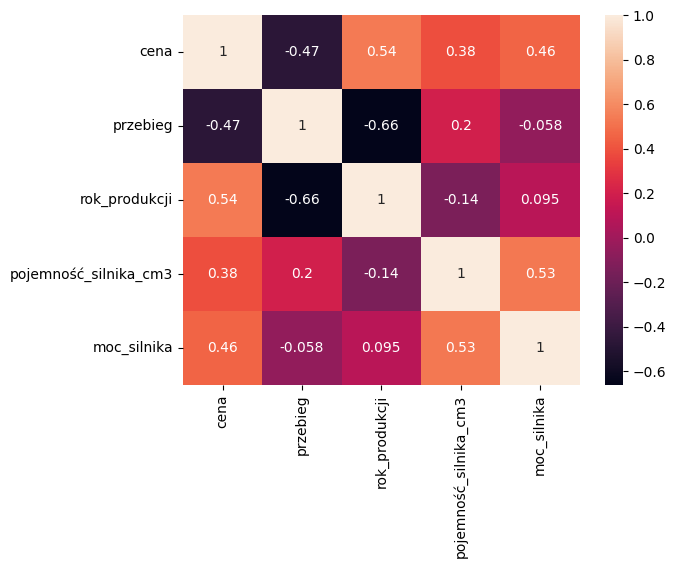

In [17]:
mask =['cena', 'przebieg', 'rok_produkcji', 'pojemność_silnika_cm3','moc_silnika']
sns.heatmap(df[mask].corr(), annot=True)
plt.show()

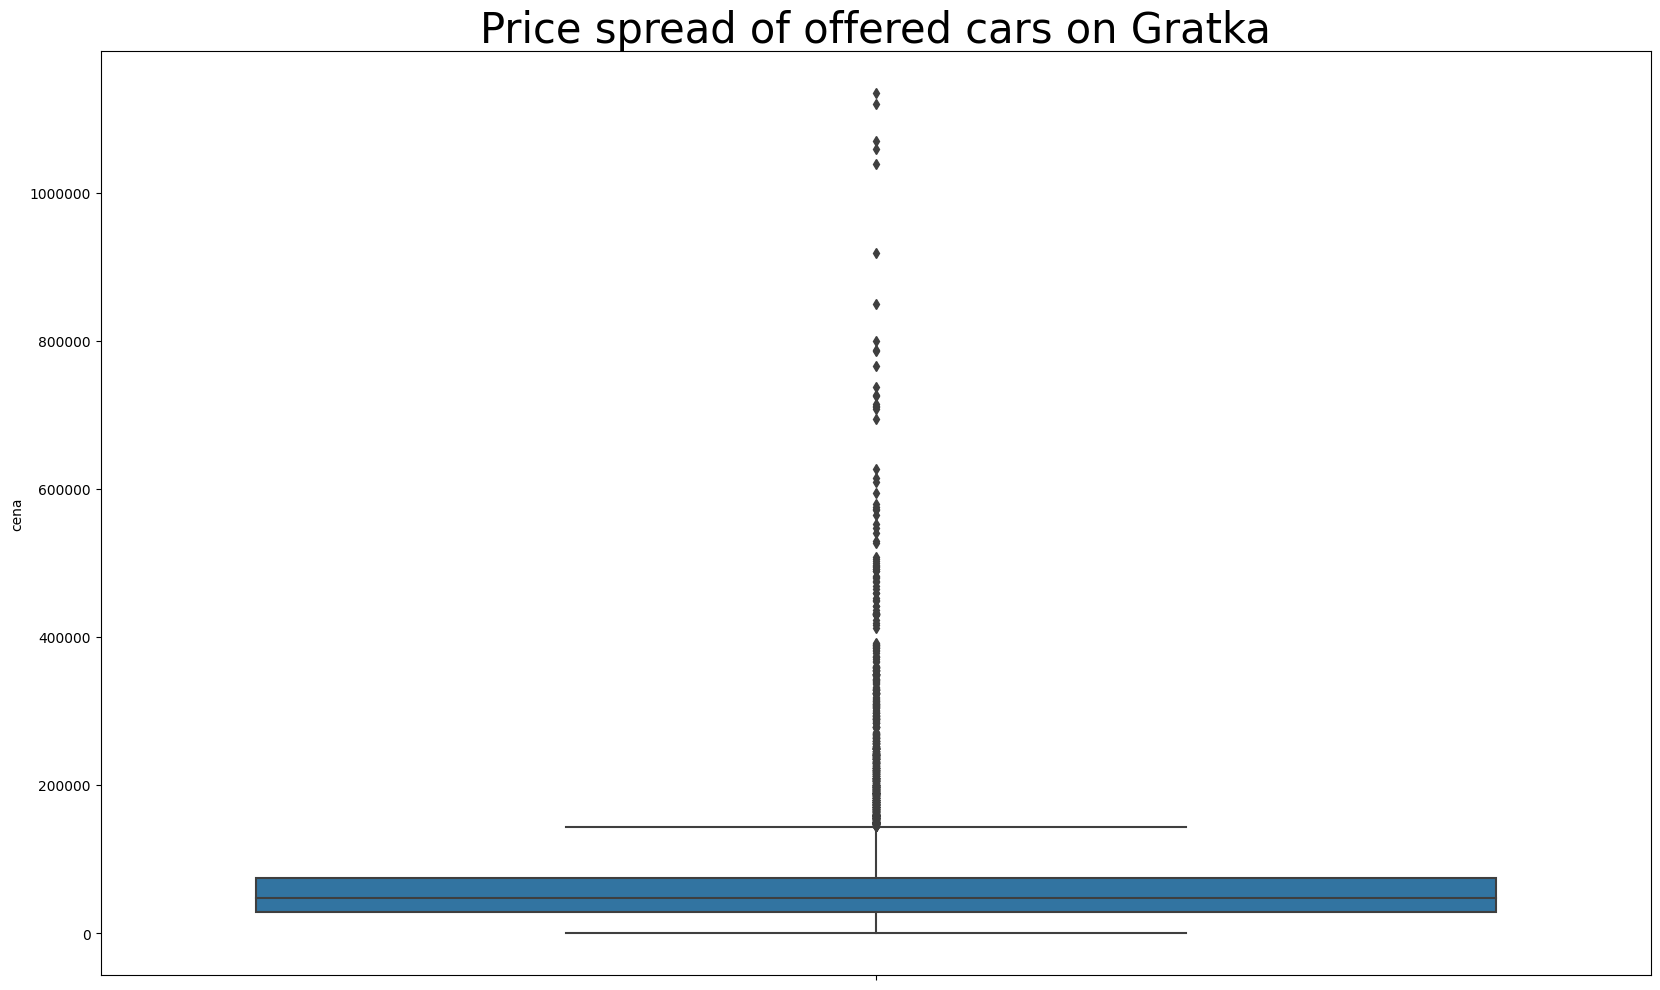

In [18]:
plt.figure(figsize=(20, 12))
plt.title('Price spread of offered cars on Gratka',fontsize=30)
sns.boxplot(y=df['cena'])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

We will look at 1% of offers with most expensive prices

In [19]:
q_99 = df.cena.quantile(0.99) 

In [20]:
df_99 = df[df['cena'] >= q_99]
mask = ['marka','model','cena','przebieg','moc_silnika', 'pojemność_silnika_cm3', 'rok_produkcji']
df_99 = df_99[mask].sort_values(by=['cena']).reset_index()
df_99

,index,marka,model,cena,przebieg,moc_silnika,pojemność_silnika_cm3,rok_produkcji
0,9774,Toyota,Land Cruiser VI,353400.0,0.0,204.0,2755.0,2022.0
1,5773,Toyota,Land Cruiser VI,353400.0,0.0,204.0,2755.0,2022.0
2,361,Porsche,Macan I,354900.0,0.0,265.0,1984.0,2022.0
3,5850,Audi,SQ5,355900.0,1621.0,354.0,2995.0,2022.0
4,5396,Audi,Q7 II,355900.0,0.0,231.0,2967.0,2022.0
...,...,...,...,...,...,...,...,...
94,9178,Mercedes-Benz,AMG GT,1038800.0,0.0,639.0,3982.0,2022.0
95,9810,Mercedes-Benz,Klasa SL R231,1059000.0,0.0,585.0,3982.0,2022.0
96,392,Porsche,911 991,1070000.0,22000.0,450.0,2981.0,2021.0
97,7645,Ferrari,488,1120000.0,18890.0,669.0,3902.0,2015.0


Most popular brand in this set

In [21]:
df_99['marka'].value_counts()

Mercedes-Benz    33
BMW              27
Audi             17
Porsche          12
Toyota            4
Land Rover        2
Lamborghini       2
Ford              1
Ferrari           1
Name: marka, dtype: int64

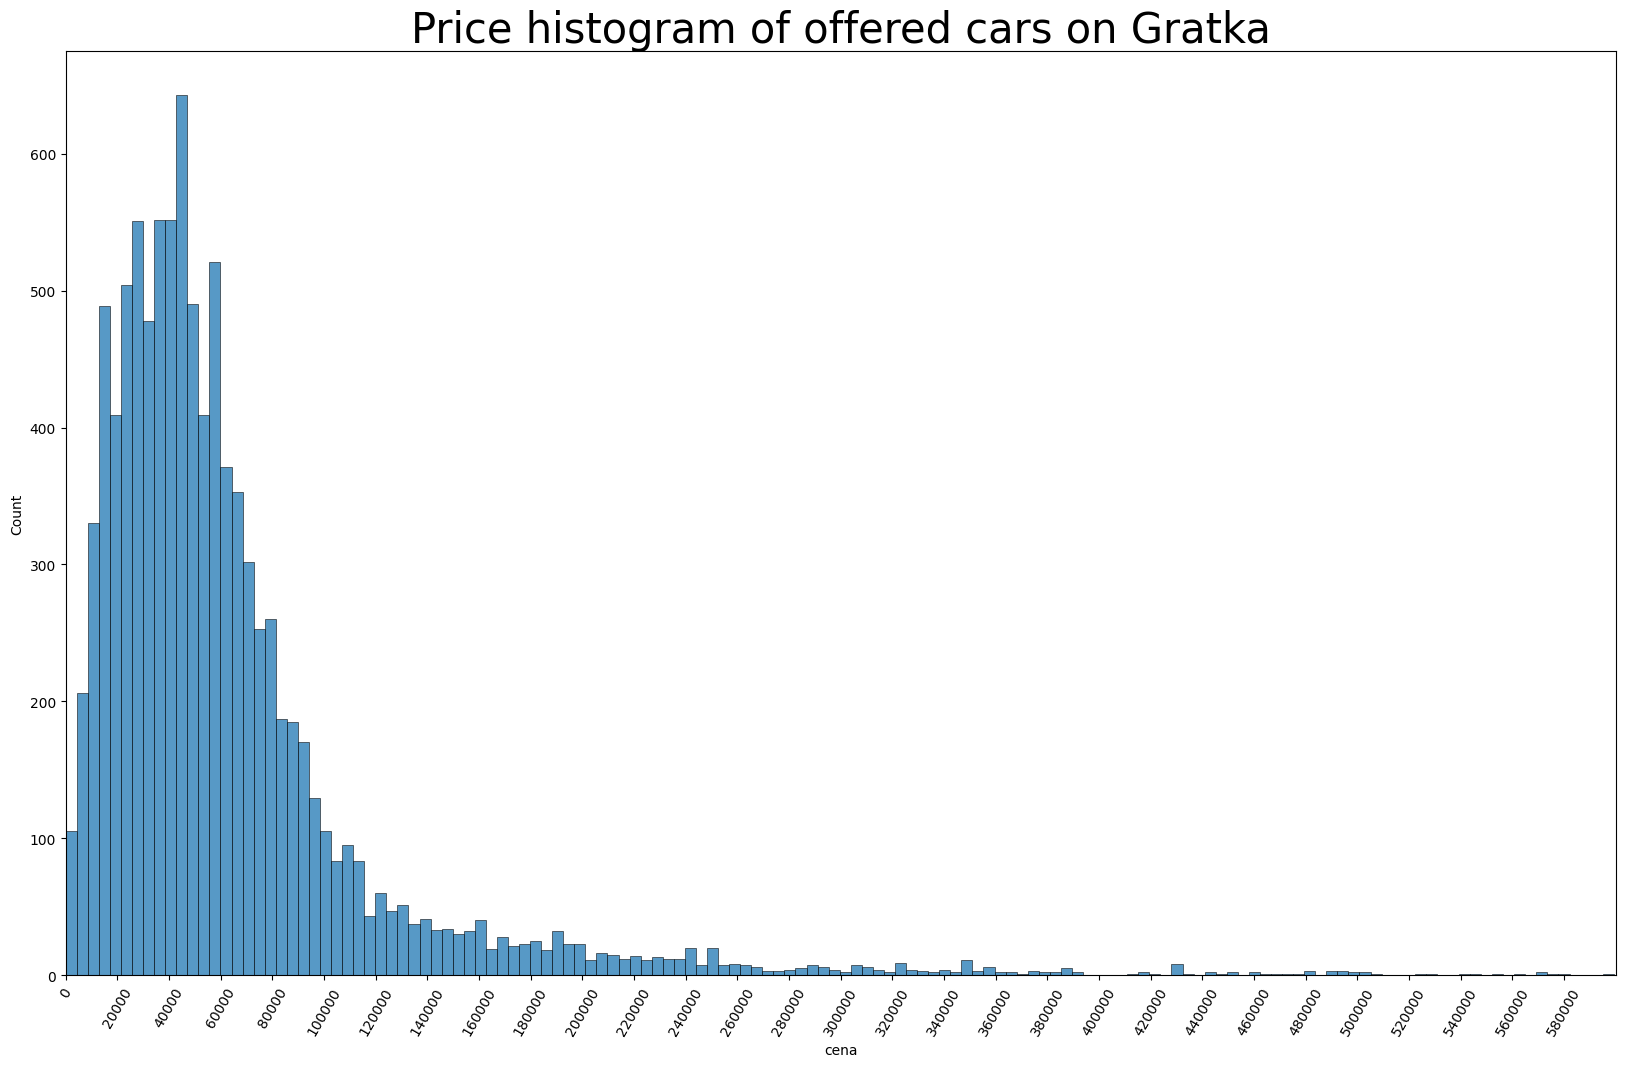

In [22]:
plt.figure(figsize=(20, 12))
plt.title('Price histogram of offered cars on Gratka',fontsize=30)
sns.histplot(df.cena)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=60,ticks=range(0,600000,20000))
pylab.xlim(0,600000)
plt.show()

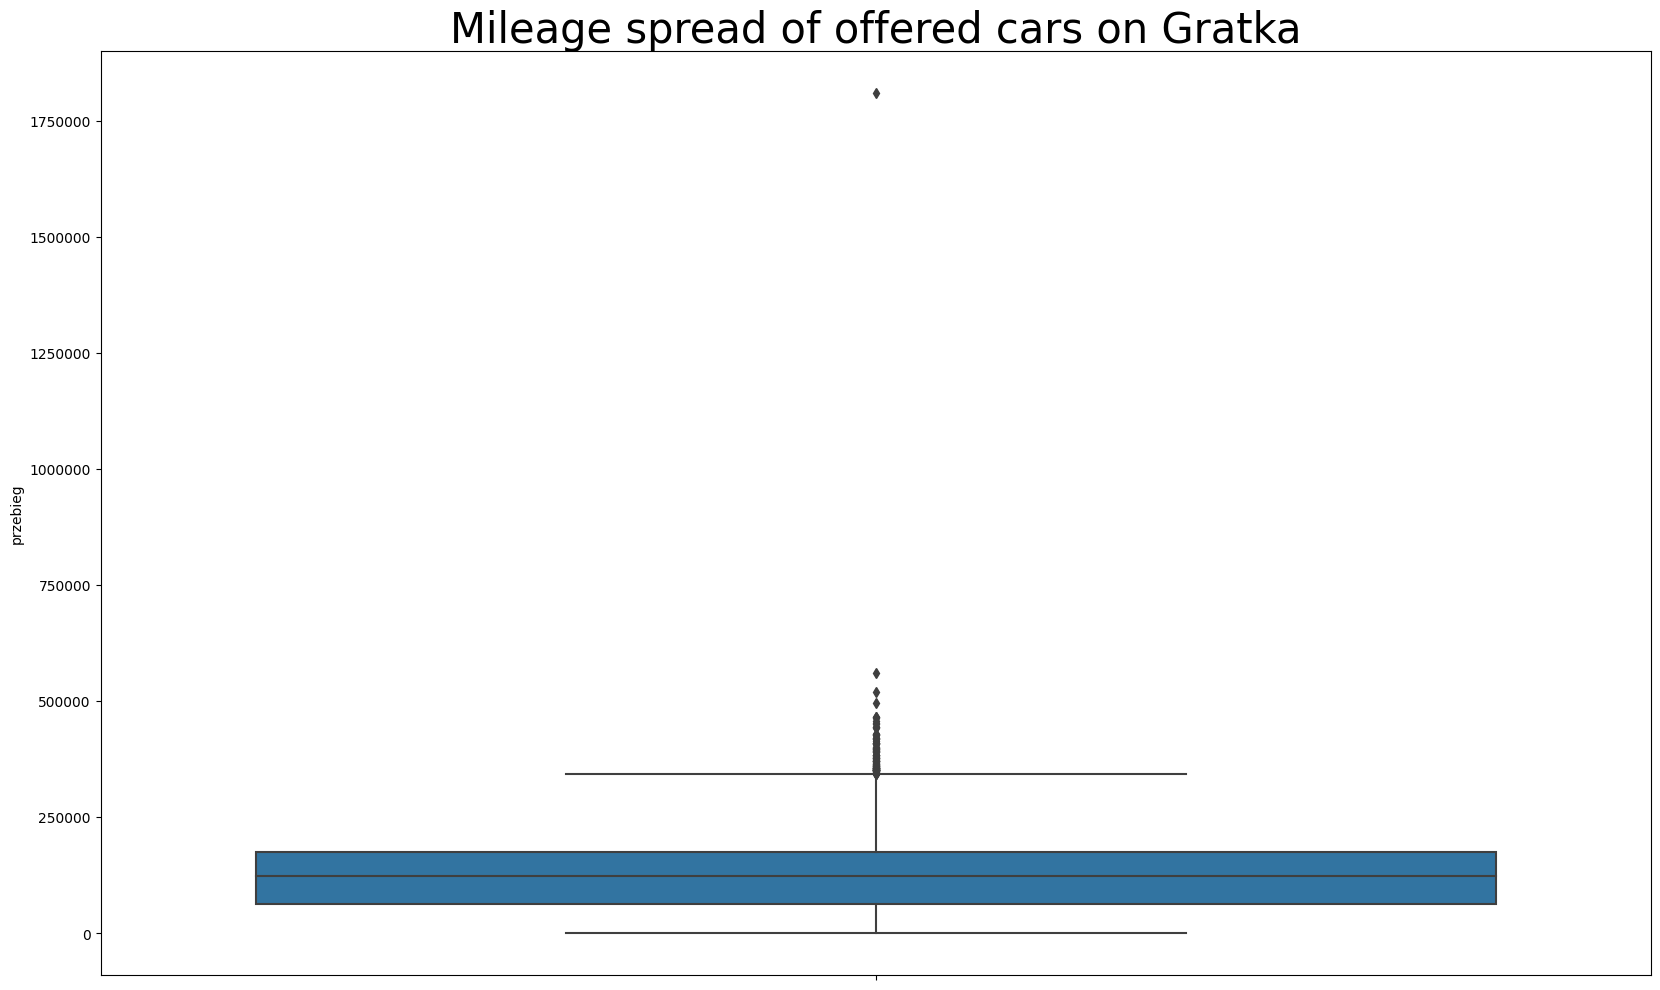

count       9853.00
mean      124073.46
std        81773.24
min            0.00
25%        63050.00
50%       123945.00
75%       174700.00
max      1810000.00
Name: przebieg, dtype: object

In [23]:
plt.figure(figsize=(20, 12))
plt.title('Mileage spread of offered cars on Gratka',fontsize=30)
sns.boxplot(y=df.przebieg)
plt.ticklabel_format(style='plain', axis='y')
plt.show()
df.przebieg.describe().apply("{0:.2f}".format)

The most interesting is car with the biggest mielage but we will look at 1% of offers with the biggest mileage

In [24]:
q_99 = df.przebieg.quantile(0.99) 

In [25]:
df_99 = df[df['przebieg'] >= q_99]
mask = ['marka','model','cena','przebieg','moc_silnika', 'pojemność_silnika_cm3', 'rok_produkcji']
df_99 = df_99[mask].sort_values(by=['przebieg']).reset_index().drop(labels=['index'],axis=1)
df_99

,marka,model,cena,przebieg,moc_silnika,pojemność_silnika_cm3,rok_produkcji
0,Alfa Romeo,156 I,4900.0,340000.0,110.0,1910.0,2001.0
1,Mercedes-Benz,Klasa E W211,23550.0,340000.0,204.0,3200.0,2005.0
2,BMW,SERIA 5 F07/F10/F11,48900.0,340000.0,258.0,2993.0,2011.0
3,Citroen,C5 III,13900.0,340000.0,140.0,1997.0,2010.0
4,Citroen,Xsara Picasso I,5400.0,340157.0,116.0,1749.0,2002.0
...,...,...,...,...,...,...,...
94,Volkswagen,Passat B5,8450.0,466000.0,130.0,1900.0,2003.0
95,Volkswagen,Transporter T5,42900.0,496503.0,102.0,1968.0,2010.0
96,Mercedes-Benz,Klasa E W211,22900.0,520000.0,150.0,2200.0,2002.0
97,Renault,Trafic II,43700.0,560957.0,114.0,2000.0,2011.0


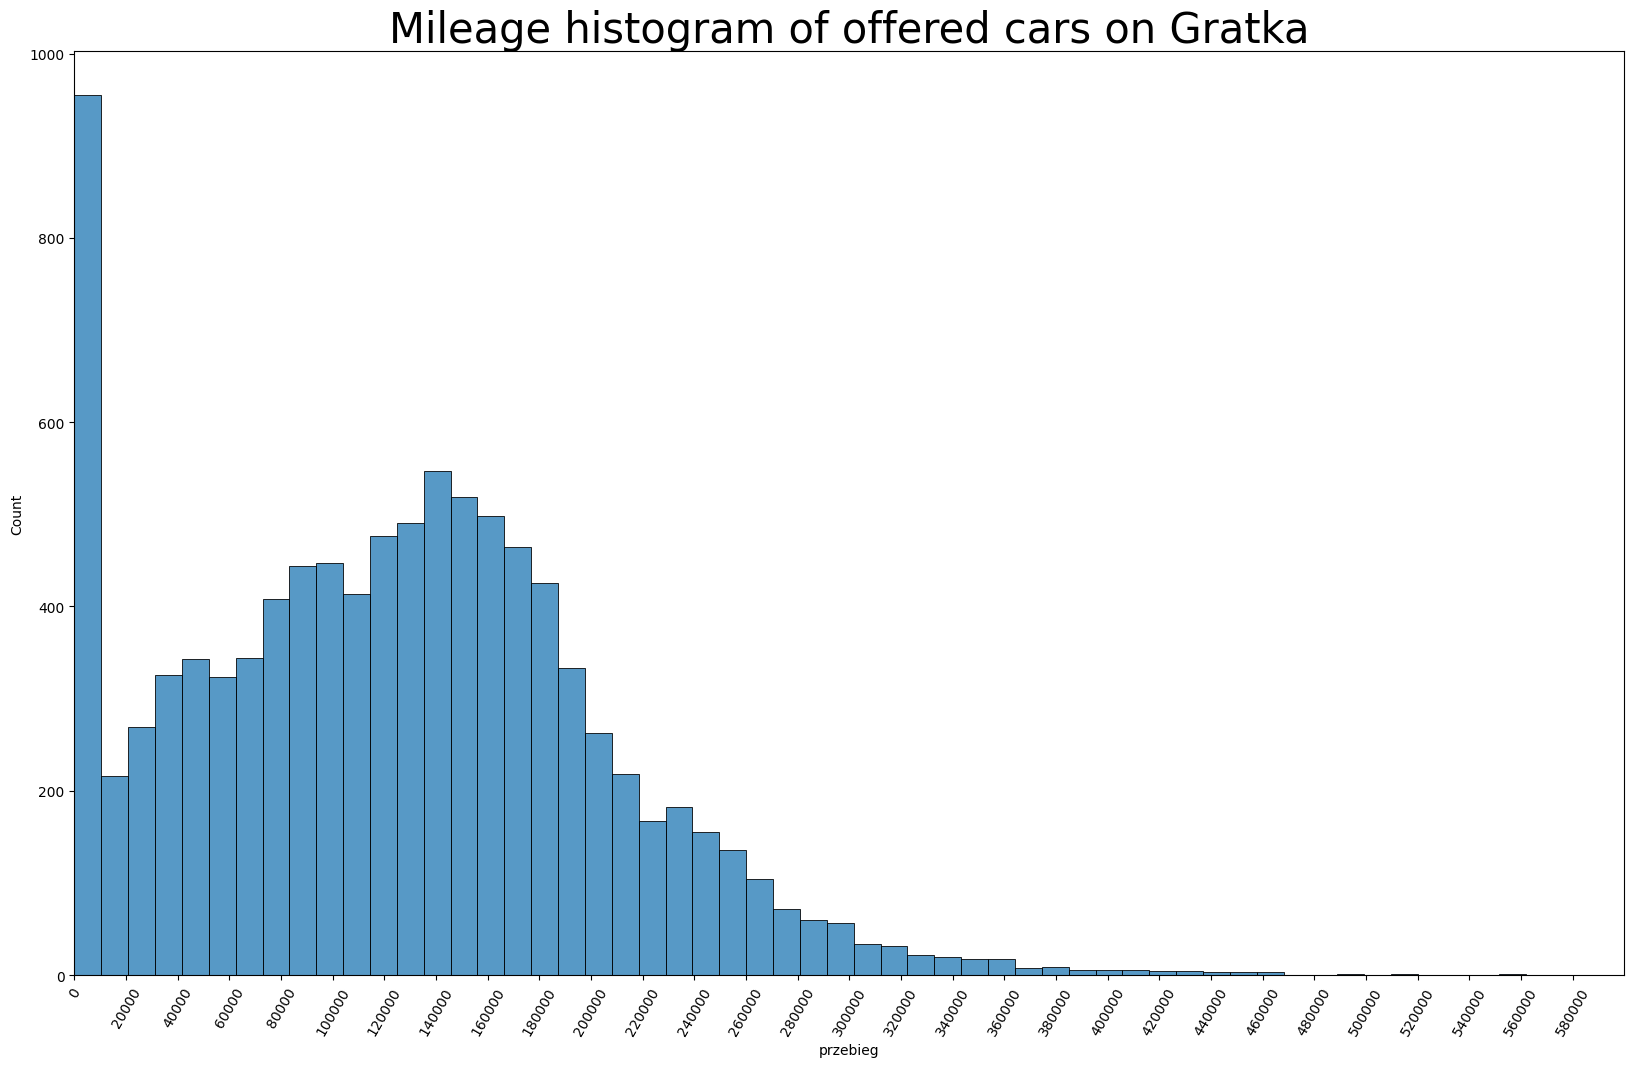

In [26]:
plt.figure(figsize=(20, 12))
plt.title('Mileage histogram of offered cars on Gratka',fontsize=30)
sns.histplot(df.przebieg)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=60,ticks=range(0,600000,20000))
pylab.xlim(0,600000)
plt.show()

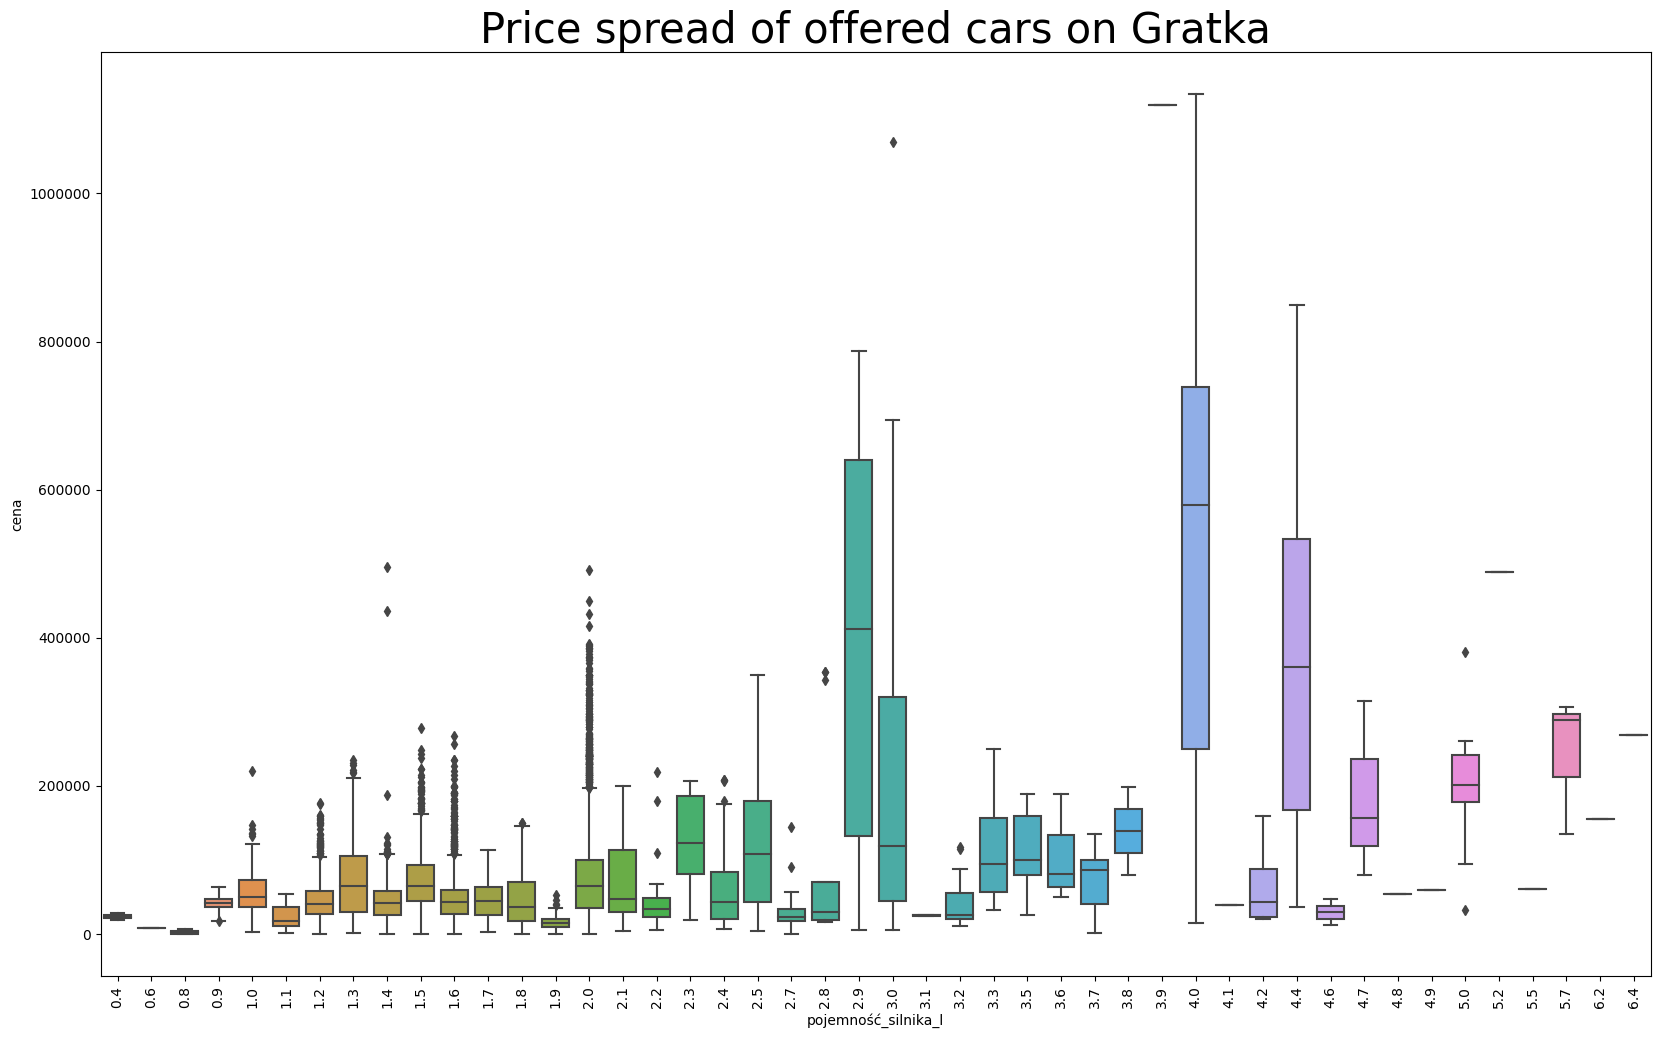

In [27]:
plt.figure(figsize=(20, 12))
plt.title('Price spread of offered cars on Gratka', fontsize=30)
sns.boxplot(y=df.cena,x=df.pojemność_silnika_l)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()

The biggest spread of car price when 2.9, 4.0 and 4.4 litres. So we will check which cars are offered with this engine size

In [28]:
df_es_2_9 = df[df['pojemność_silnika_l'] == 2.9]
mask = ['marka','model','cena','przebieg','moc_silnika', 'pojemność_silnika_l', 'rok_produkcji']
df_es_2_9 = df_es_2_9[mask].reset_index().drop(labels=['index'],axis=1)
df_es_2_9

,marka,model,cena,przebieg,moc_silnika,pojemność_silnika_l,rok_produkcji
0,Mercedes-Benz,Inny,786875.0,0.0,330.0,2.9,2022.0
1,Mercedes-Benz,Klasa S W222,725166.0,0.0,330.0,2.9,2022.0
2,Porsche,Panamera,615200.0,0.0,330.0,2.9,2022.0
3,BMW,SERIA 3 E46,12900.0,304463.0,180.0,2.9,2002.0
4,Mercedes-Benz,Klasa G W464,714500.0,6915.0,286.0,2.9,2020.0
5,Kia,Carnival II,10000.0,375564.0,185.0,2.9,2008.0
6,Mercedes-Benz,Klasa G W464,766000.0,15932.0,286.0,2.9,2022.0
7,Kia,Carnival I,5999.0,260000.0,145.0,2.9,2004.0
8,Alfa Romeo,Inny,309900.0,29000.0,510.0,2.9,2019.0
9,Audi,RS4 B8,159900.0,107000.0,450.0,2.9,2018.0


In [29]:
df_es_4_0 = df[df['pojemność_silnika_l'] == 4.0]
mask = ['marka','model','cena','przebieg','moc_silnika', 'pojemność_silnika_l', 'rok_produkcji']
df_es_4_0 = df_es_4_0[mask].reset_index().drop(labels=['index'],axis=1)
df_es_4_0

,marka,model,cena,przebieg,moc_silnika,pojemność_silnika_l,rok_produkcji
0,Mercedes-Benz,Klasa GLE W167,459000.0,44000.0,489.0,4.0,2020.0
1,Mercedes-Benz,Inny,367524.0,87200.0,550.0,4.0,2018.0
2,Audi,Q8 I,579900.0,47000.0,435.0,4.0,2020.0
3,Audi,Q7 II,526300.0,0.0,507.0,4.0,2022.0
4,Audi,Q8 I,918000.0,0.0,600.0,4.0,2022.0
5,Audi,S6 C7,69990.0,235200.0,540.0,4.0,2012.0
6,Audi,Q7 II,539800.0,0.0,507.0,4.0,2022.0
7,Audi,A6 C8,711400.0,0.0,600.0,4.0,2022.0
8,Mercedes-Benz,AMG GT,1134346.0,0.0,639.0,4.0,2022.0
9,Jeep,Grand Cherokee Z,15000.0,325000.0,180.0,4.0,1995.0


In [30]:
df_es_4_4 = df[df['pojemność_silnika_l'] == 4.4]
mask = ['marka','model','cena','przebieg','moc_silnika', 'pojemność_silnika_l', 'rok_produkcji']
df_es_4_4 = df_es_4_4[mask].reset_index().drop(labels=['index'],axis=1)
df_es_4_4

,marka,model,cena,przebieg,moc_silnika,pojemność_silnika_l,rok_produkcji
0,BMW,M5 F10,459900.0,27000.0,600.0,4.4,2018.0
1,BMW,X5 F15,169700.0,51660.0,450.0,4.4,2015.0
2,BMW,SERIA 8 G15,358700.0,25270.0,530.0,4.4,2018.0
3,BMW,M5 F10,159900.0,1.0,600.0,4.4,2021.0
4,BMW,Inny,785970.0,4395.0,625.0,4.4,2021.0
5,BMW,X5 F15,189900.0,73000.0,450.0,4.4,2017.0
6,BMW,M5 F10,849000.0,5000.0,635.0,4.4,2021.0
7,BMW,X6 E71,116500.0,169000.0,680.0,4.4,2011.0
8,BMW,SERIA 7 F01/F02,35800.0,172000.0,408.0,4.4,2011.0
9,BMW,SERIA 8 G16,361324.8,82366.0,530.0,4.4,2020.0


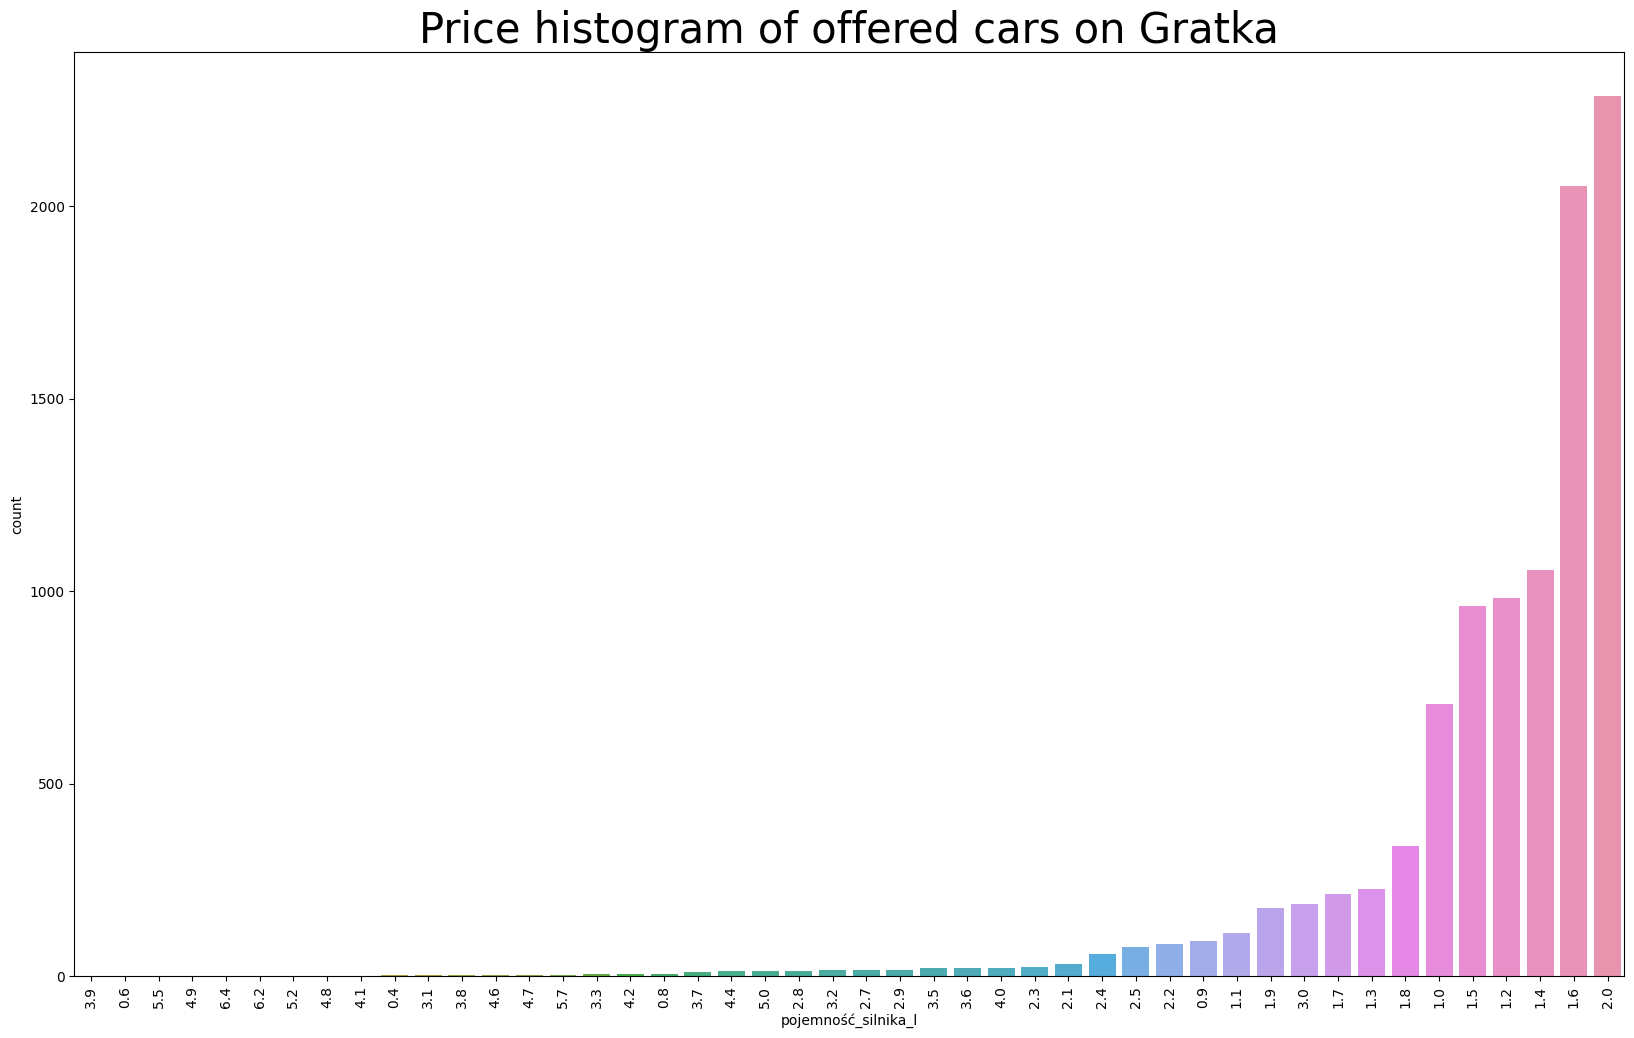

In [31]:
plt.figure(figsize=(20, 12))
plt.title('Price histogram of offered cars on Gratka', fontsize=30)
order = df.pojemność_silnika_l.value_counts(ascending=True).index
sns.countplot(x='pojemność_silnika_l',data=df, order=order)
plt.xticks(rotation=90)
plt.show()


(0.0, 600000.0)

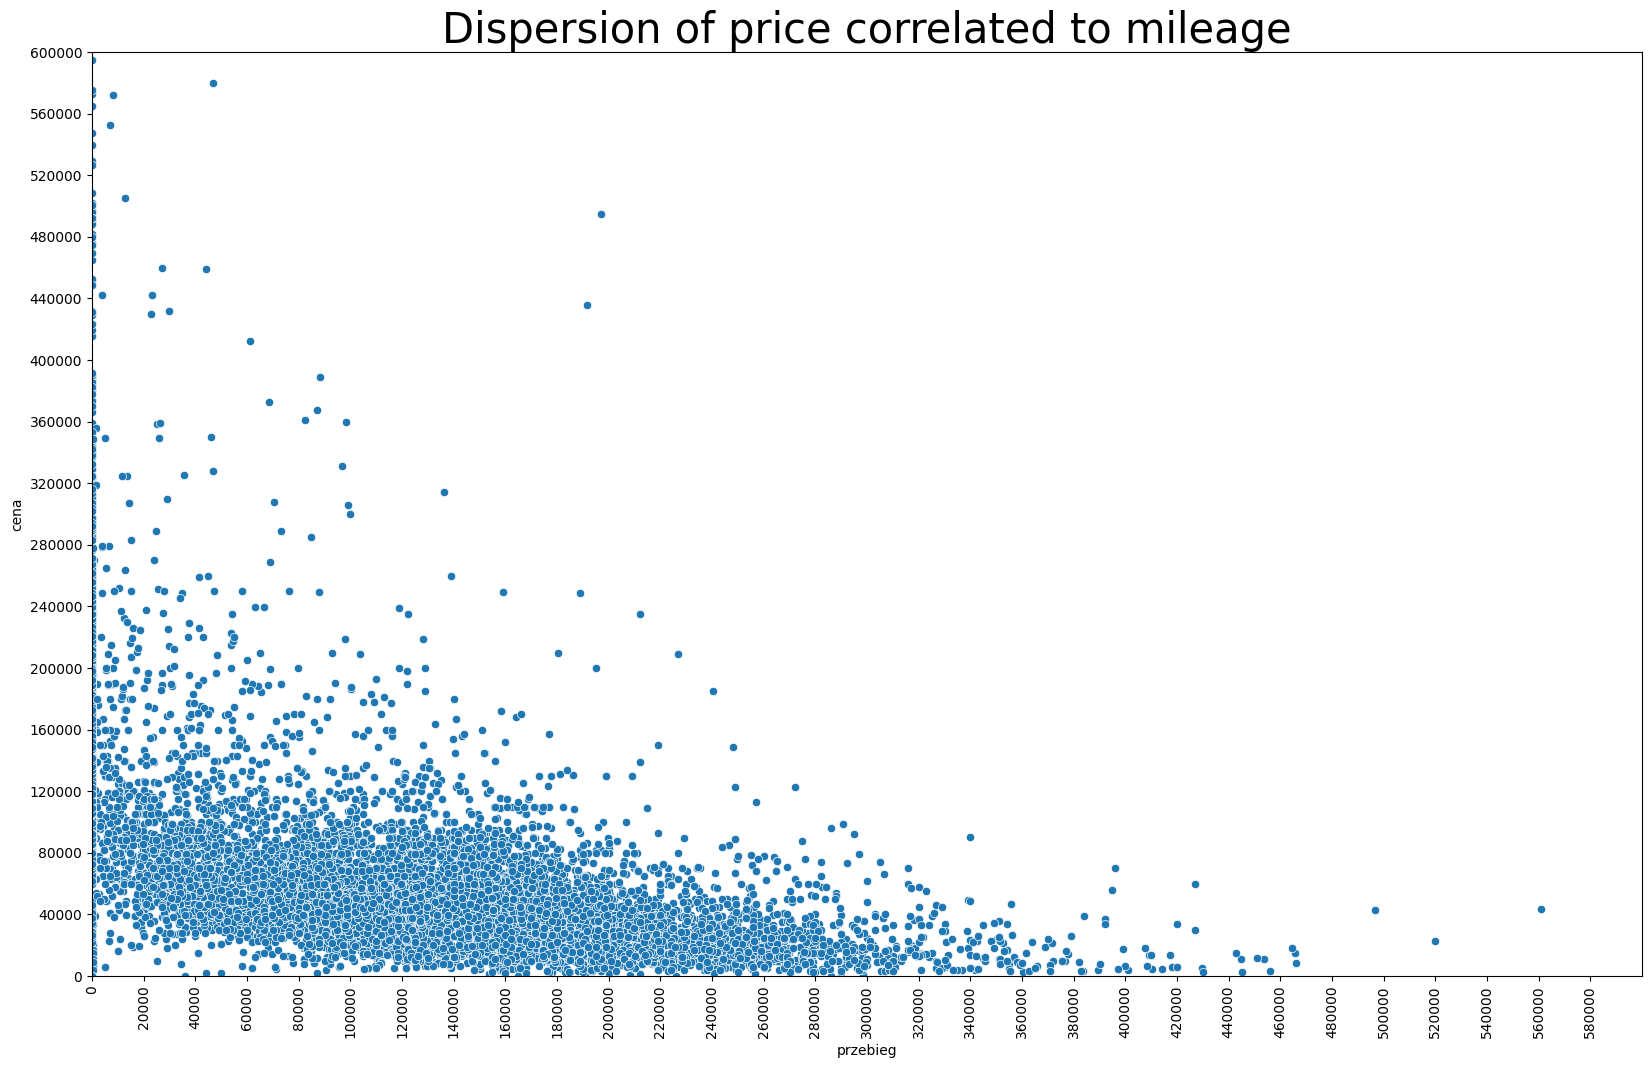

In [32]:
plt.figure(figsize=(20, 12))
plt.title('Dispersion of price correlated to mileage', fontsize=30)
sns.scatterplot(data=df, x="przebieg", y="cena")
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=90,ticks=range(0,600000,20000))
plt.ticklabel_format(style='plain', axis='y')
plt.yticks(ticks=range(0,700000,40000))
pylab.xlim(0,600000)
pylab.ylim(0,600000)

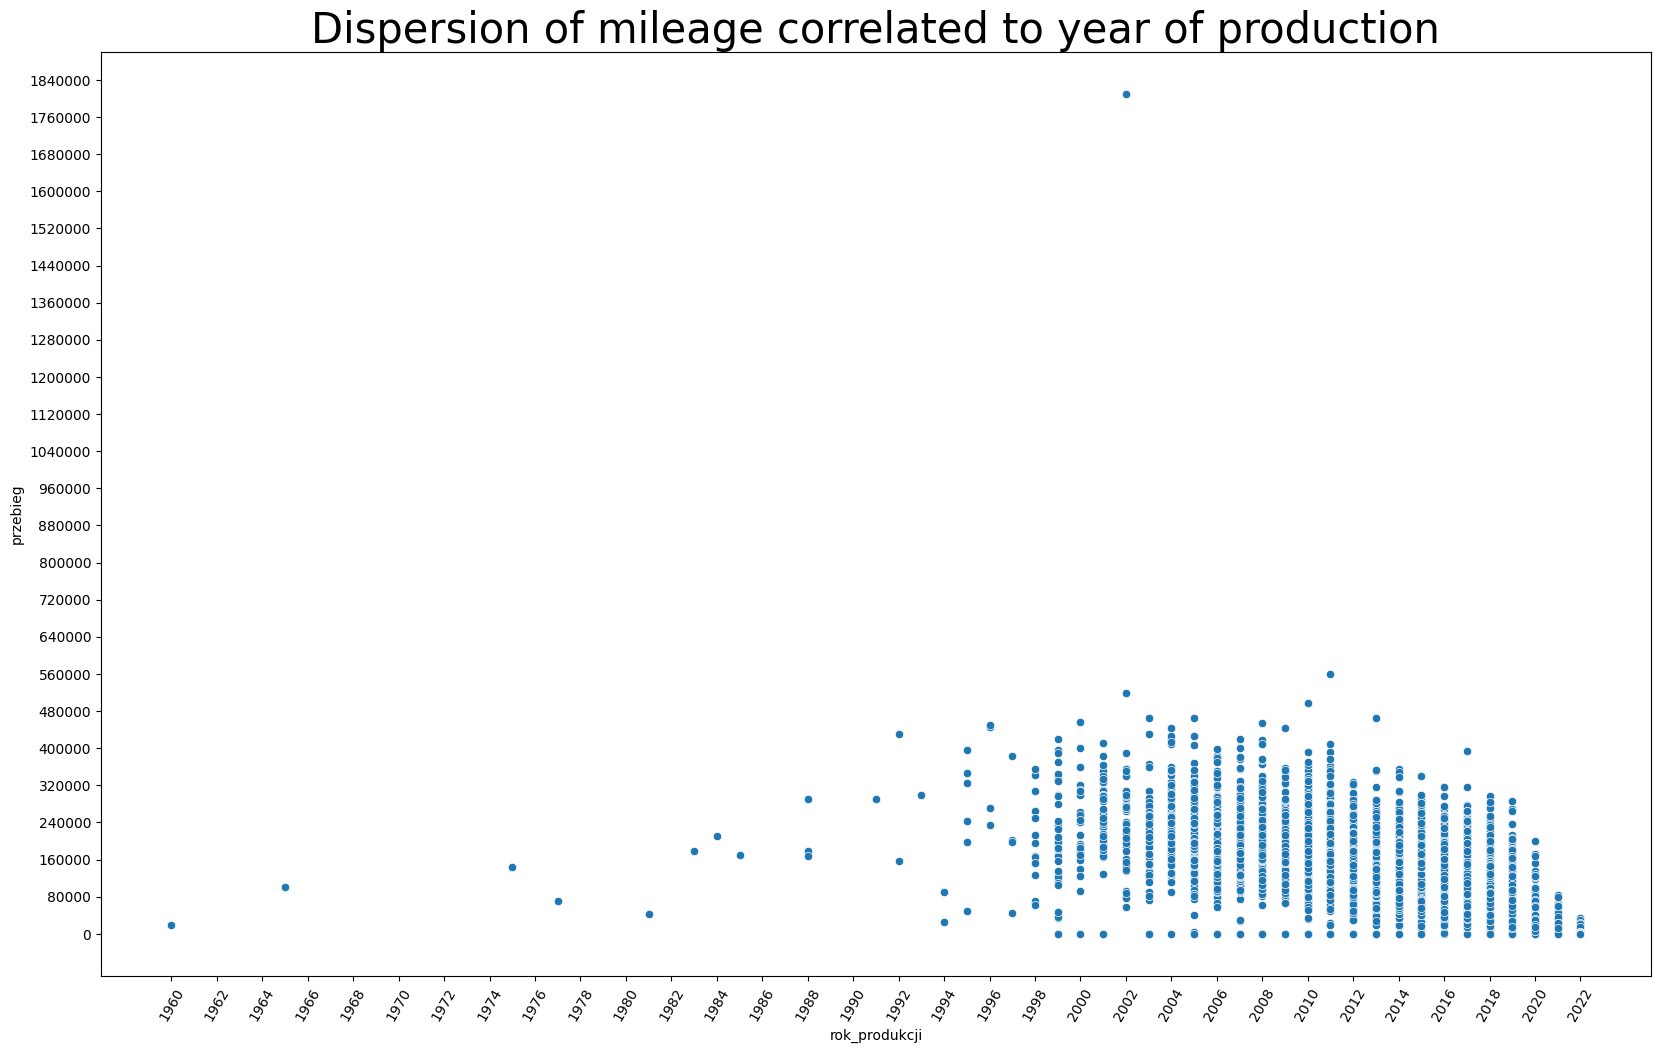

In [33]:
plt.figure(figsize=(20, 12))
plt.title('Dispersion of mileage correlated to year of production', fontsize=30)
sns.scatterplot(data=df, x="rok_produkcji", y="przebieg")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=60,ticks=range(1960,2024,2))
plt.yticks(ticks=range(0,1880000,80000))
plt.show()

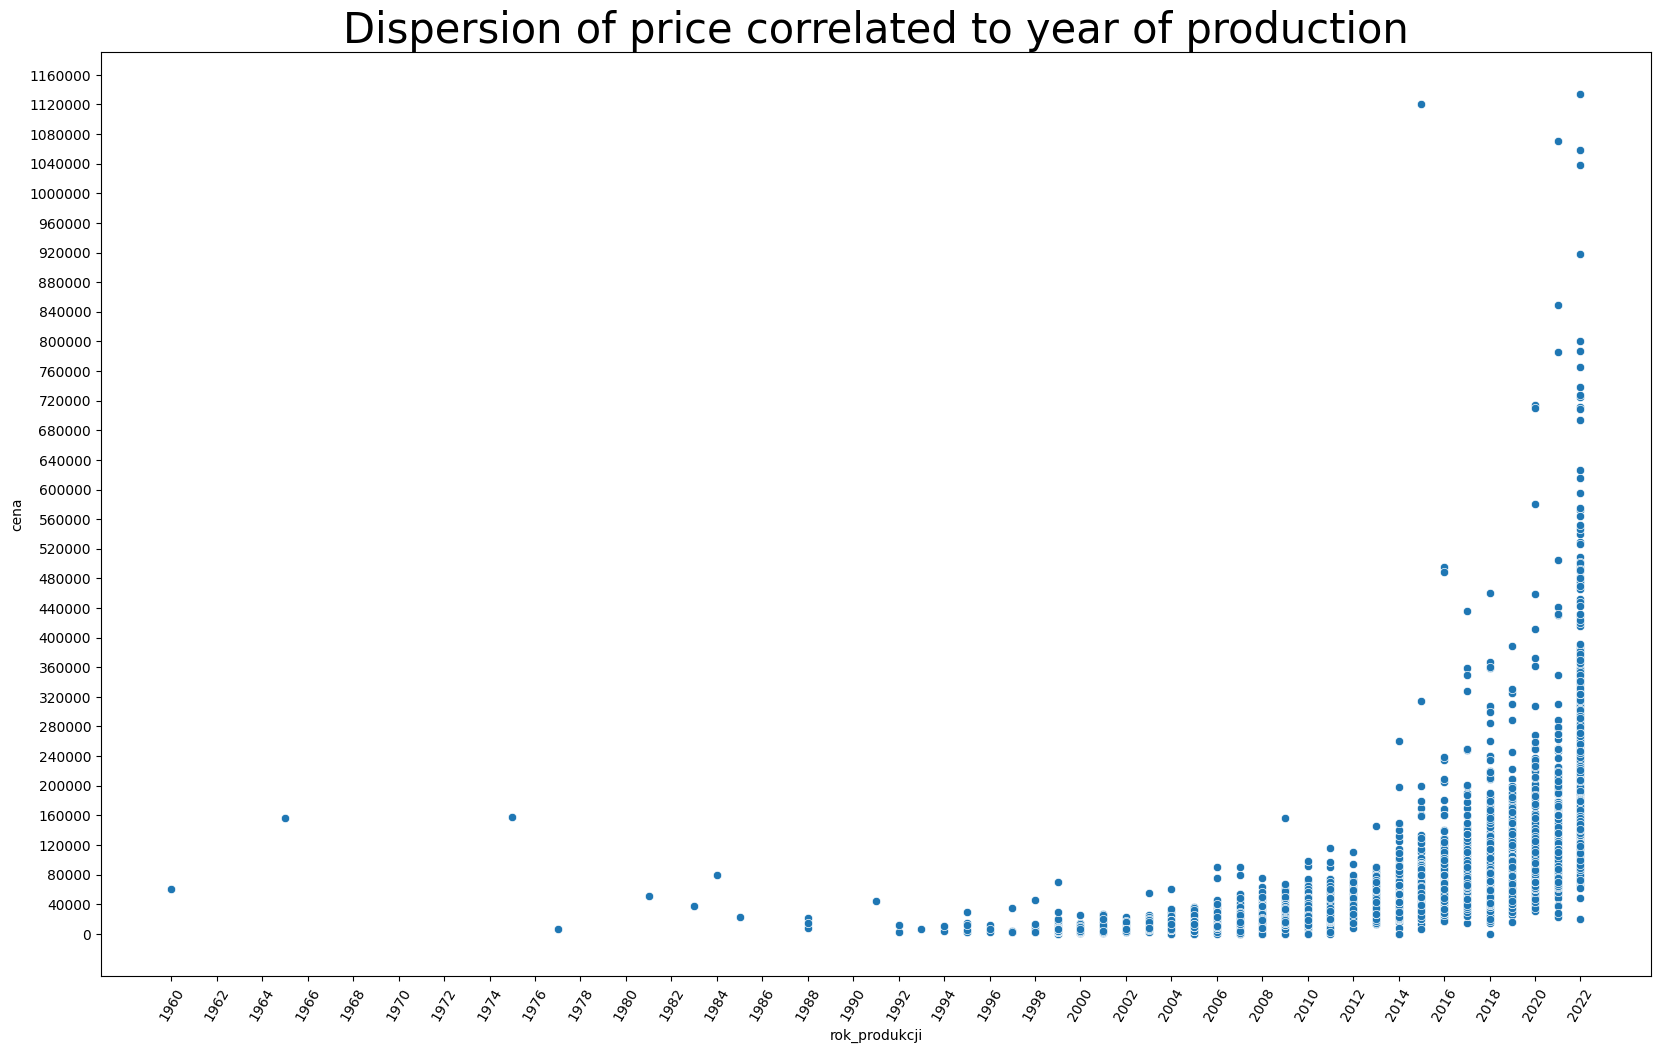

In [34]:
plt.figure(figsize=(20, 12))
plt.title('Dispersion of price correlated to year of production', fontsize=30)
sns.scatterplot(data=df, x="rok_produkcji", y="cena")
plt.ticklabel_format(style='plain', axis='y')
plt.yticks(ticks=range(0,1200000,40000))
plt.xticks(rotation=60,ticks=range(1960,2024,2))
plt.show()

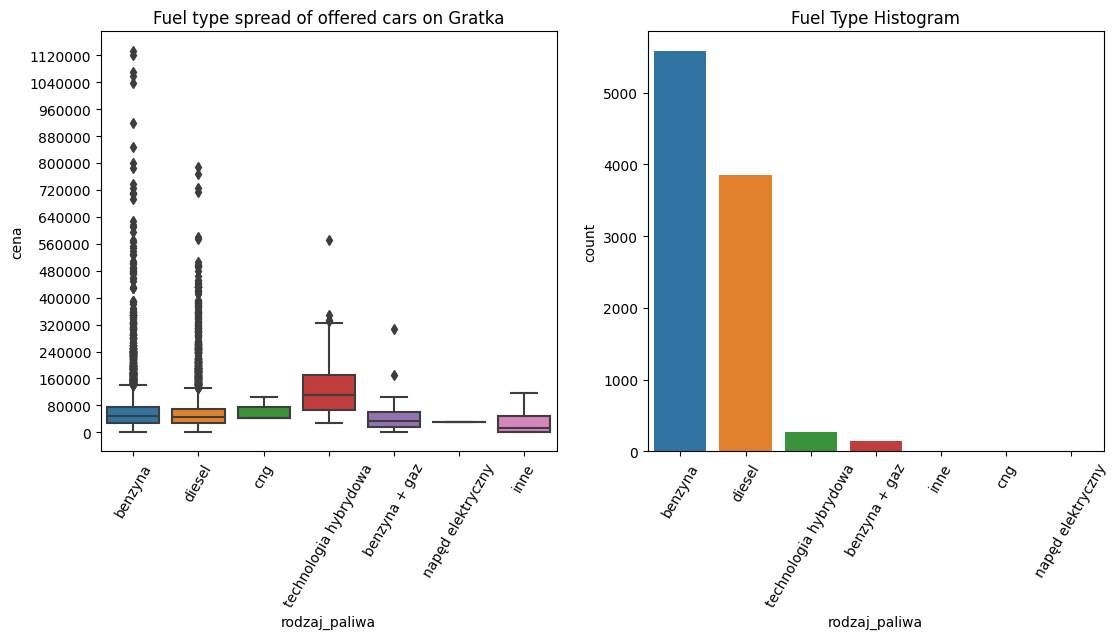

In [35]:
plt.figure(figsize=(20, 12))

plt.subplot(2,3,1)
plt.title('Fuel type spread of offered cars on Gratka')
sns.boxplot(x = 'rodzaj_paliwa', y= 'cena', data=df)
plt.ticklabel_format(style='plain', axis='y')
plt.yticks(ticks=range(0,1200000,80000))
plt.xticks(rotation=60)

plt.subplot(2,3,2)
plt.title('Fuel Type Histogram')
order = df['rodzaj_paliwa'].value_counts(ascending=False).index
sns.countplot(x='rodzaj_paliwa', data=df, order=order)
plt.xticks(rotation=60)

plt.show()

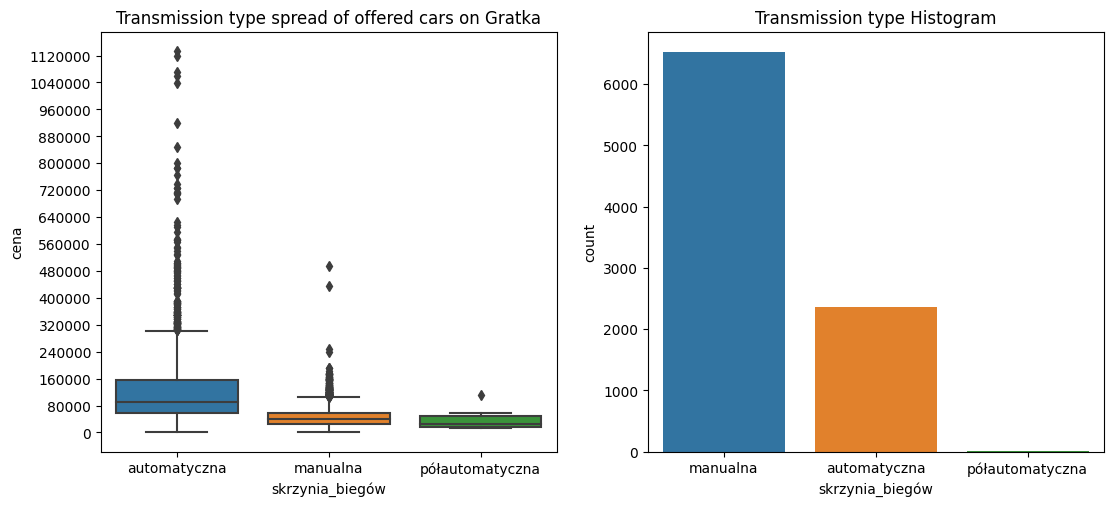

In [36]:
plt.figure(figsize=(20, 12))

plt.subplot(2,3,1)
plt.title('Transmission type spread of offered cars on Gratka')
sns.boxplot(x = 'skrzynia_biegów', y= 'cena', data=df)
plt.ticklabel_format(style='plain', axis='y')
plt.yticks(ticks=range(0,1200000,80000))

plt.subplot(2,3,2)
plt.title('Transmission type Histogram')
order = df['skrzynia_biegów'].value_counts(ascending=False).index
sns.countplot(x='skrzynia_biegów', data=df, order=order)

plt.show()

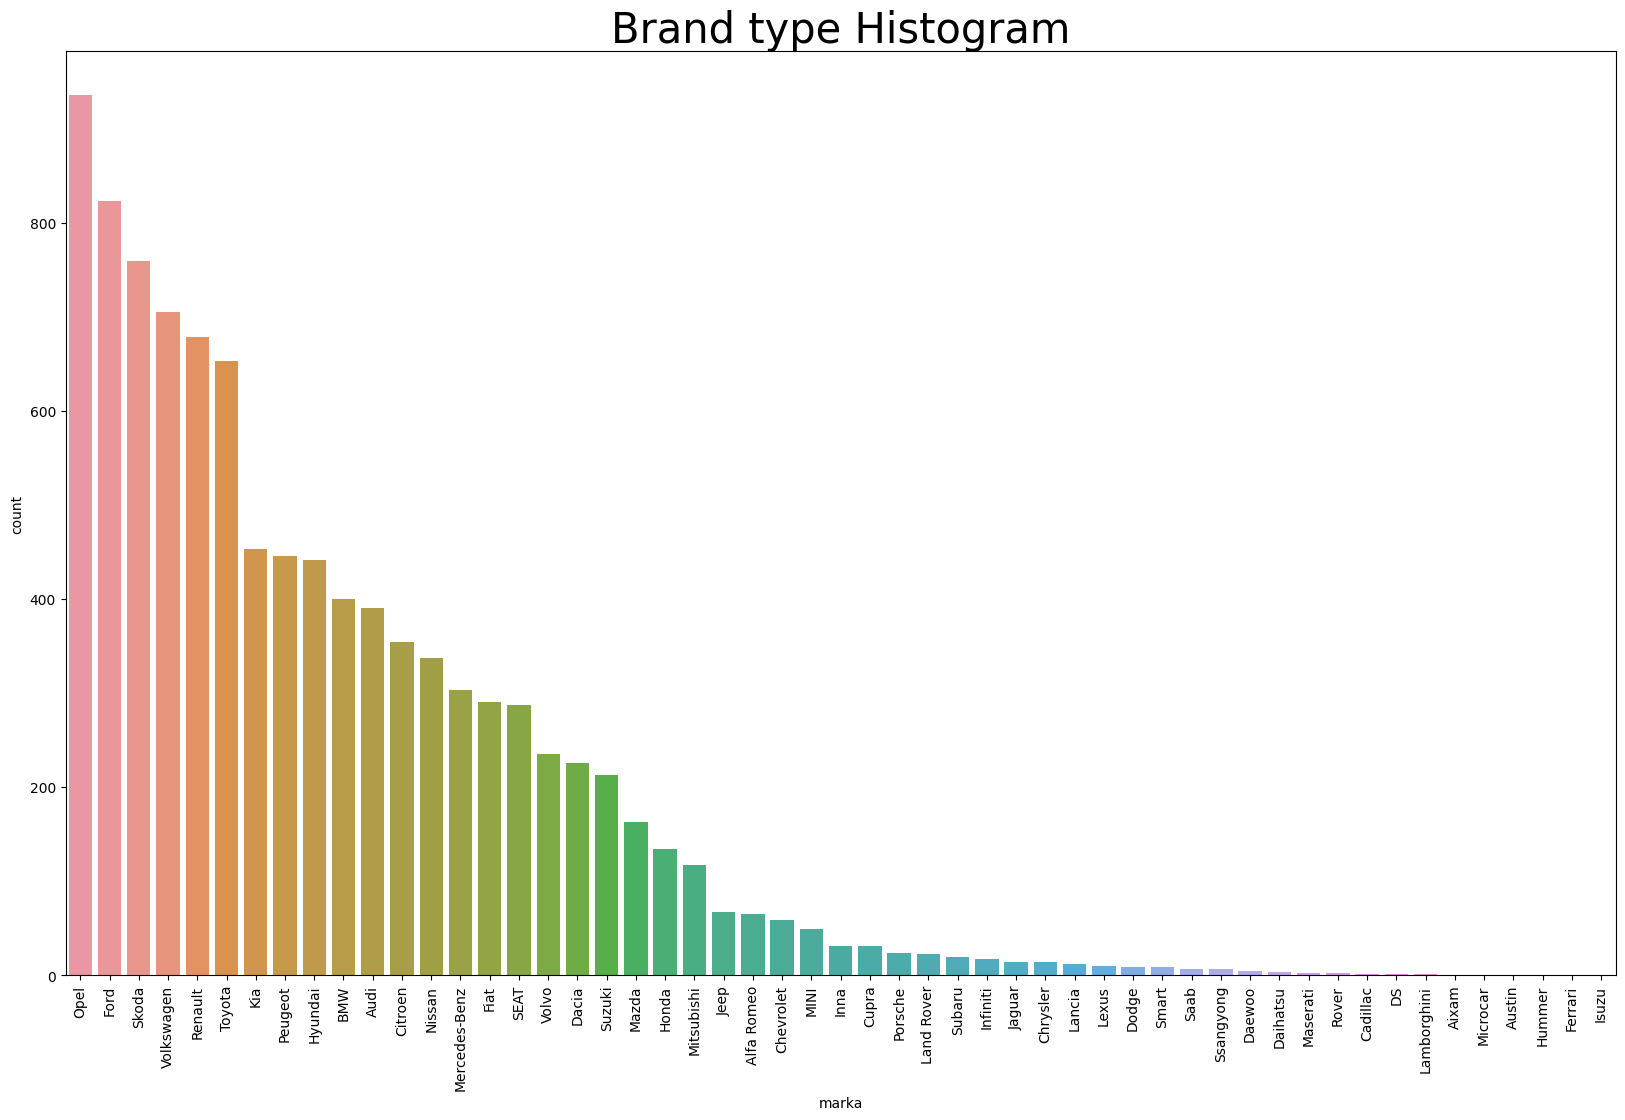

In [37]:
plt.figure(figsize=(20, 12))
plt.title('Brand type Histogram', fontsize=30)
order = df['marka'].value_counts(ascending=False).index
sns.countplot(x='marka', data=df, order=order)
plt.xticks(rotation=90)

plt.show()

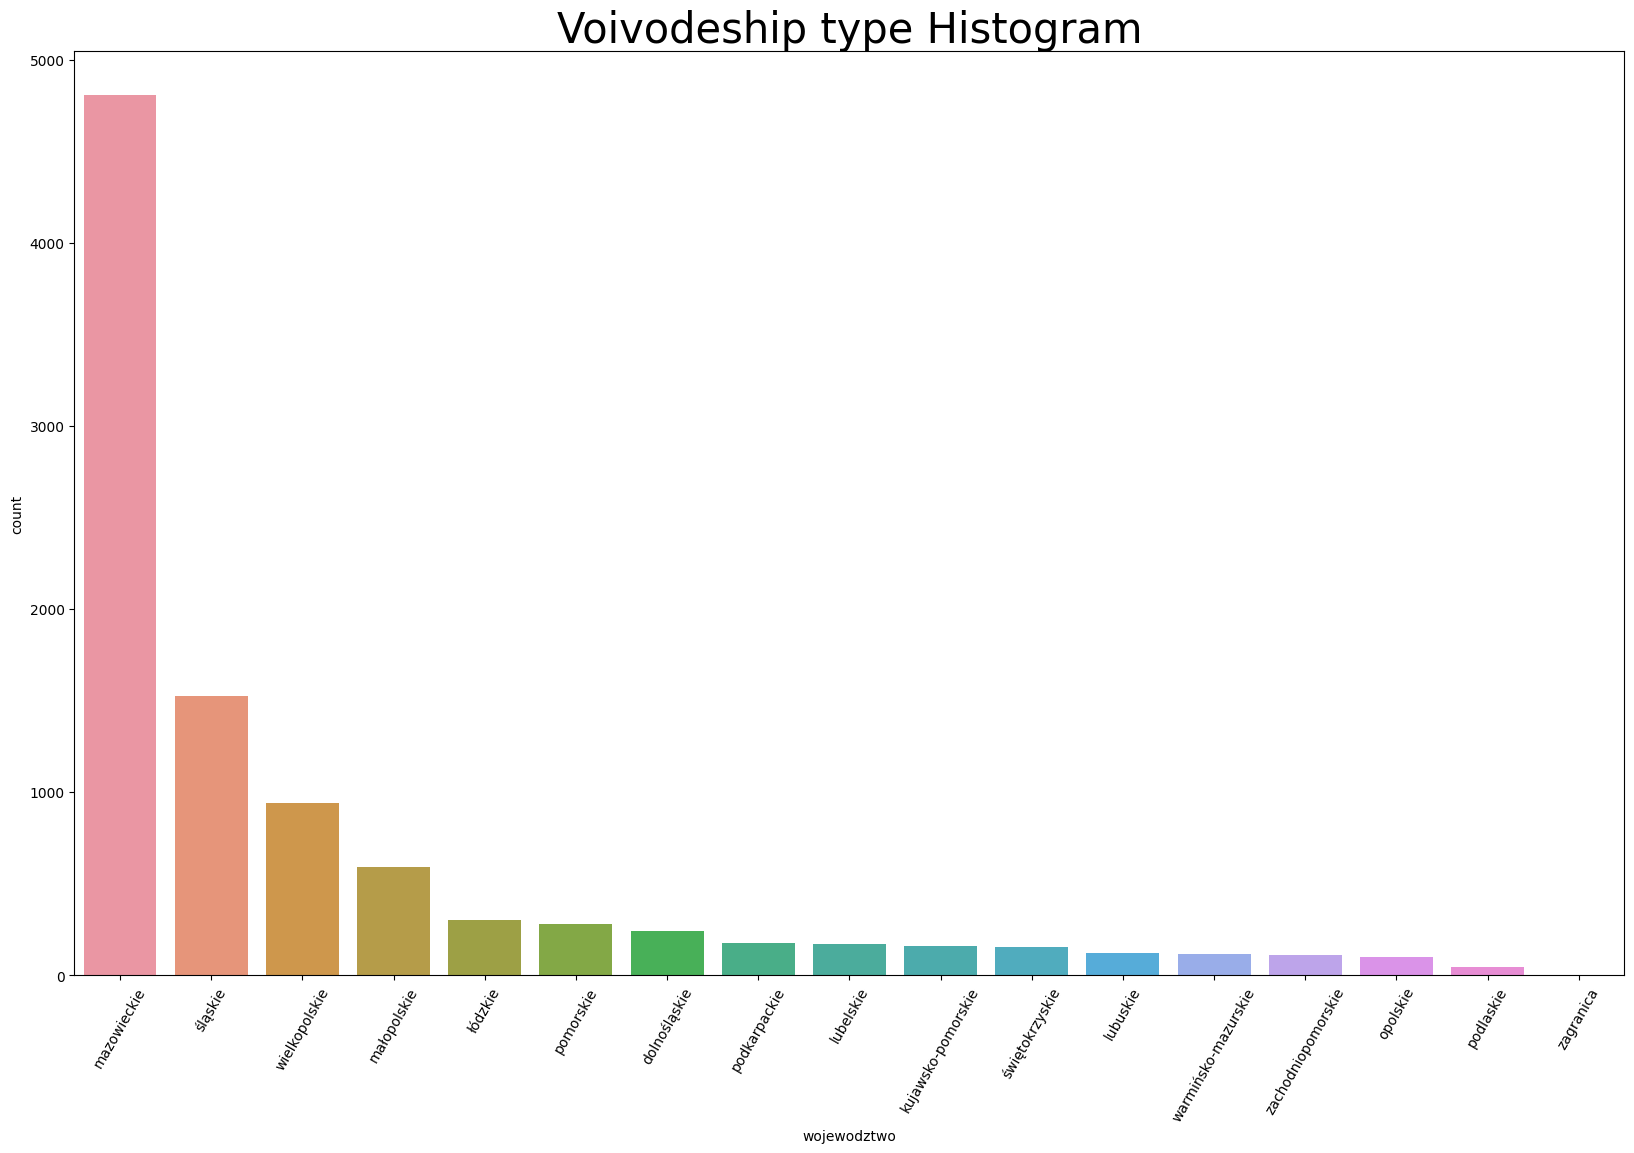

In [38]:
plt.figure(figsize=(20, 12))
plt.title('Voivodeship type Histogram', fontsize=30)
order = df['wojewodztwo'].value_counts(ascending=False).index
sns.countplot(x='wojewodztwo', data=df, order=order)
plt.xticks(rotation=60)

plt.show()

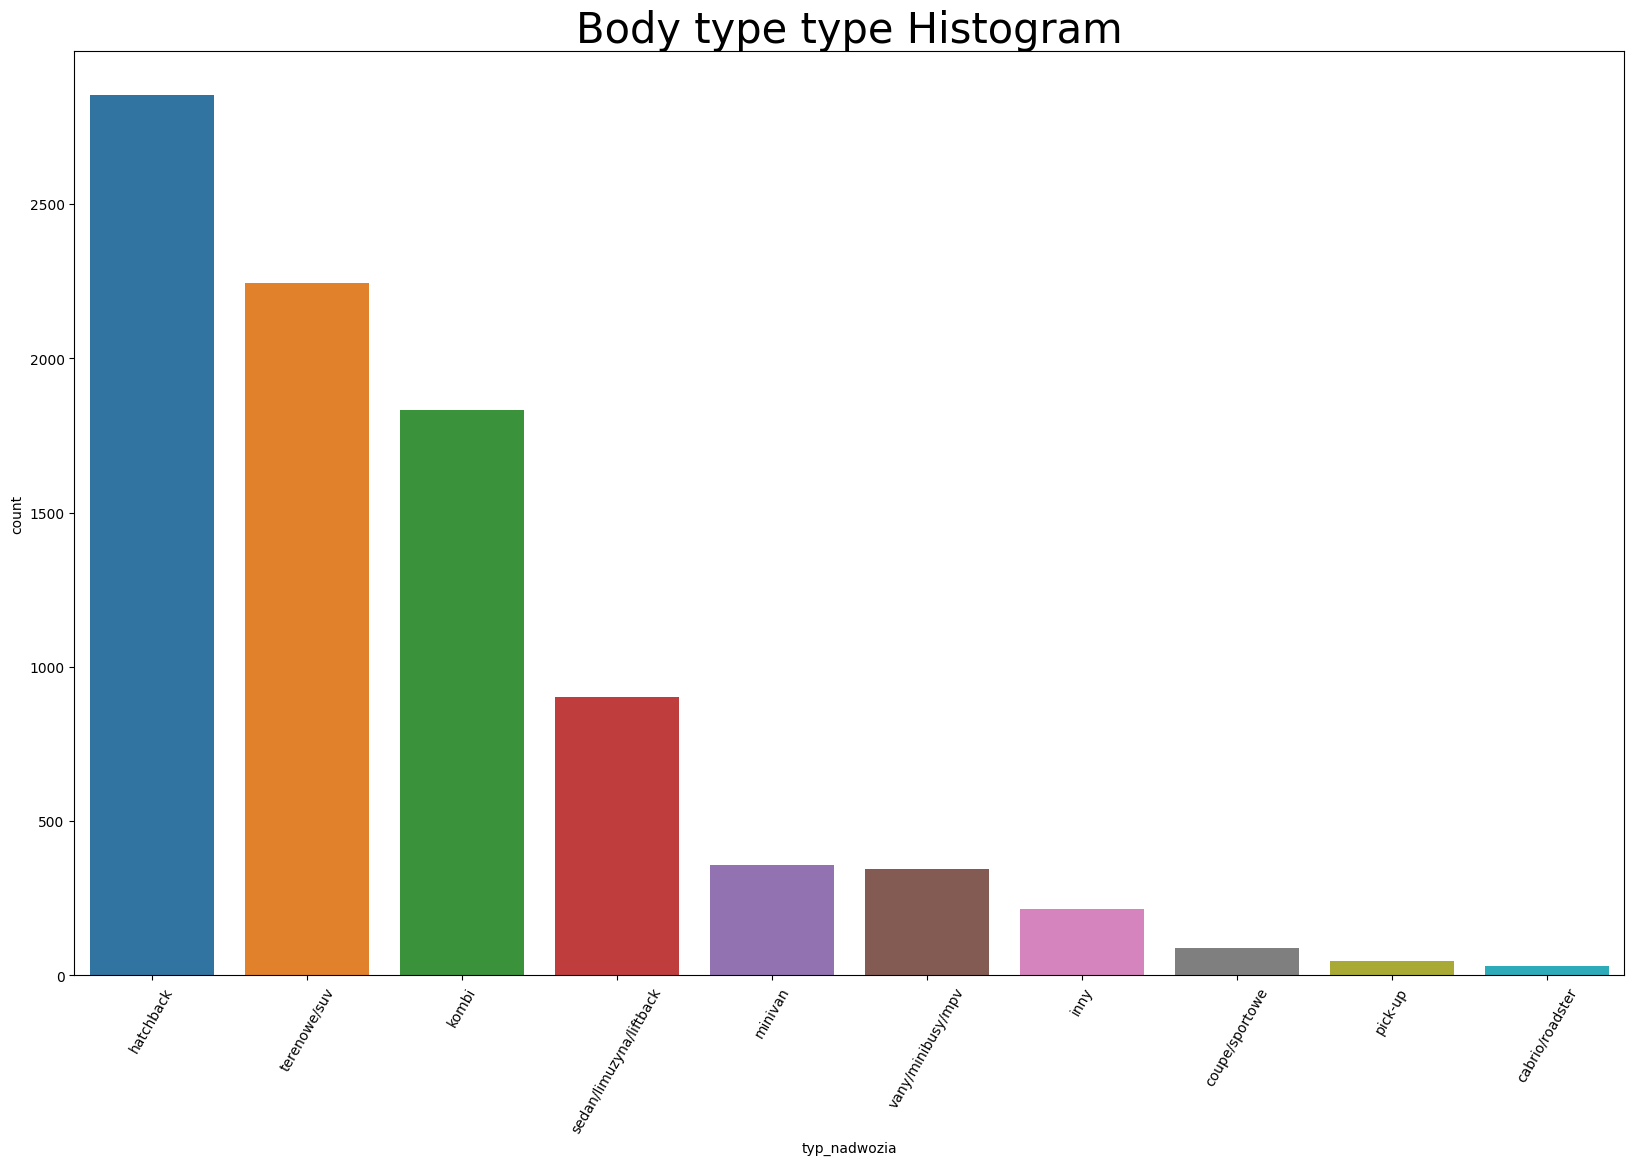

In [39]:
plt.figure(figsize=(20, 12))
plt.title('Body type type Histogram', fontsize=30)
order = df['typ_nadwozia'].value_counts(ascending=False).index
sns.countplot(x='typ_nadwozia', data=df, order=order)
plt.xticks(rotation=60)

plt.show()

Table with brand type offers on each voivodeship

In [40]:
brand_to_voivo =pd.DataFrame()
for voivo in df['wojewodztwo'].unique():
    brand_to_voivo[voivo] = df[df['wojewodztwo']==f'{voivo}']['marka'].value_counts()

Table with top 5 brands type offers on each voivodeship

In [41]:
top_5 = {}
for voivo in df['wojewodztwo'].unique():
    top_5[voivo] = df[df['wojewodztwo']==f'{voivo}']['marka'].value_counts(ascending=False)[:5]

Getting a polygon map from GIS and add voivodeship

In [42]:
mapa_woj = gpd.read_file('voivodeship.shp')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


Creating a list of voivodeship with order based on GIS table

In [43]:
mapa_woj['woj'] = ['śląskie','opolskie','świętokrzyskie',
       'pomorskie','podlaskie','zachodniopomorskie',
       'dolnośląskie','wielkopolskie','podkarpackie',
       'małopolskie','warmińsko-mazurskie','łódzkie',
       'mazowieckie','kujawsko-pomorskie','lubelskie','lubuskie']

In [44]:
mapa_woj['coords'] = mapa_woj['geometry'].apply(
    lambda x: x.representative_point().coords[:])

In [45]:
mapa_woj['coords'] = [coords[0] for coords in mapa_woj['coords']]

Mean price of advertise in each voivodeship

In [46]:
mean_price = {}
for voivo in df['wojewodztwo'].unique():
    mean_price[voivo] = {'mean': round(df[df['wojewodztwo']==f'{voivo}']['cena'].mean(),2)}
mean = pd.DataFrame(mean_price).T



In [47]:
mapa_woj= mapa_woj.join(mean, on=mapa_woj.woj)

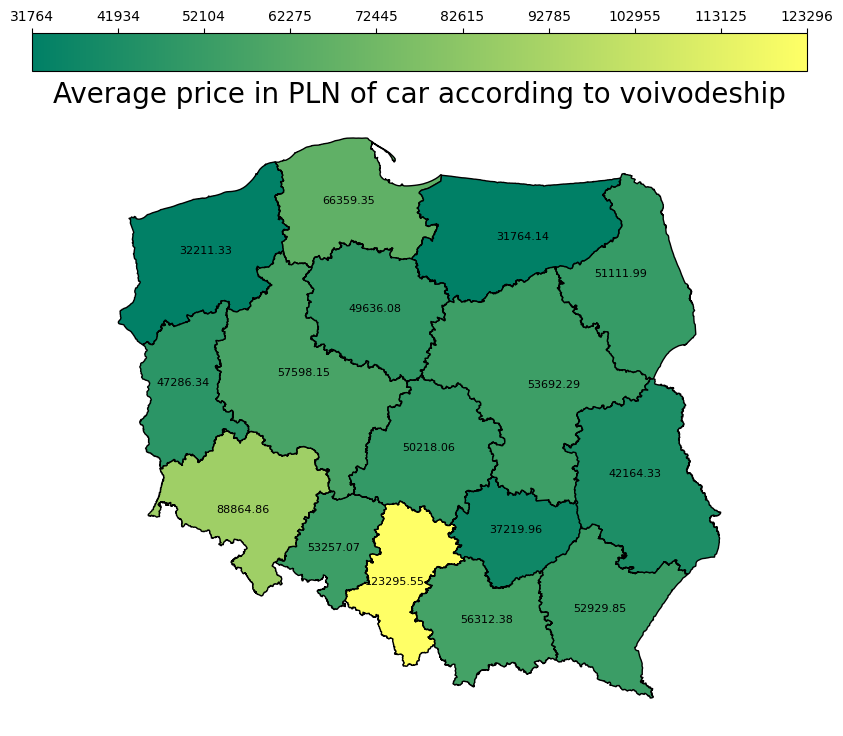

In [48]:
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Average price in PLN of car according to voivodeship', 
          fontsize=20
         )
#Creating a colormap with colorbar
vmin = mapa_woj['mean'].min()
vmax = mapa_woj['mean'].max()
mappable = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='summer')
color = [mappable.to_rgba(item) for item in mapa_woj['mean']]
fig.colorbar(mappable,ax=ax,location='top', ticks=np.linspace(start=vmin, stop=vmax, num=10))

mapa_woj.plot(ax=ax, color=color, edgecolor='black', legend=True)

ax.axis('off')
for idx, row in mapa_woj.iterrows():
    plt.annotate(text=row['mean'], xy=row['coords'], horizontalalignment='center', color='black',fontsize=8)


Median price of advertise in each voivodeship

In [49]:
median = {}
for voivo in df['wojewodztwo'].unique():
    median[voivo] = {'median': df[df['wojewodztwo']==f'{voivo}']['cena'].median()}
median = pd.DataFrame(median).T


In [50]:
mapa_woj= mapa_woj.join(median, on=mapa_woj.woj)

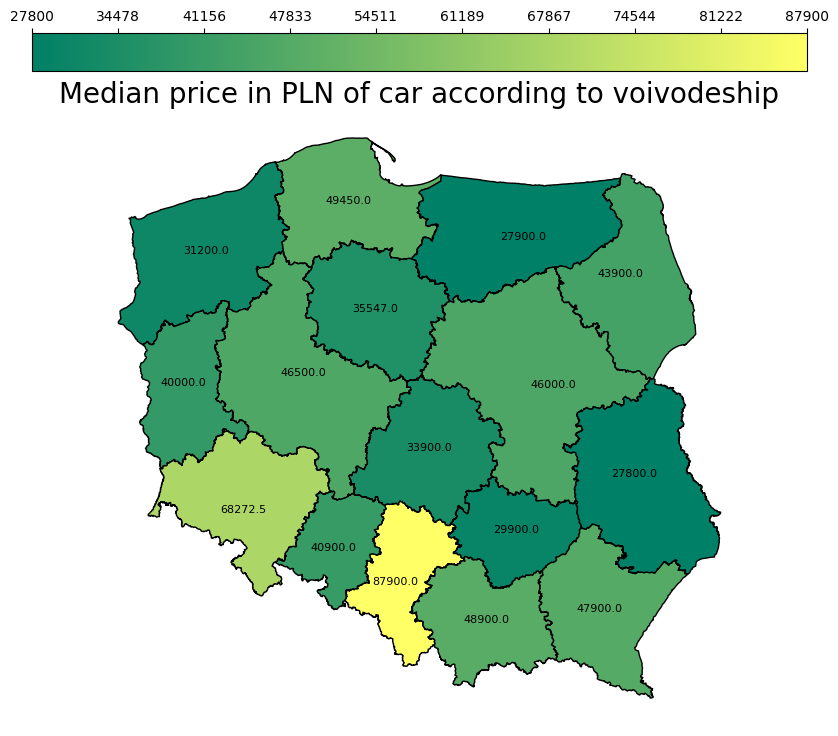

In [51]:
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Median price in PLN of car according to voivodeship', 
          fontsize=20
         )
#Creating a colormap with colorbar
vmin = mapa_woj['median'].min()
vmax = mapa_woj['median'].max()
mappable = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='summer')
color = [mappable.to_rgba(item) for item in mapa_woj['median']]
fig.colorbar(mappable,ax=ax,location='top',ticks=np.linspace(start=vmin, stop=vmax, num=10))

mapa_woj.plot(ax=ax, color=color, edgecolor='black')
ax.axis('off')
for idx, row in mapa_woj.iterrows():
    plt.annotate(
        text=row['median'], 
        xy=row['coords'], 
        horizontalalignment='center', 
        color='black',
        fontsize=8)

Median vs mean

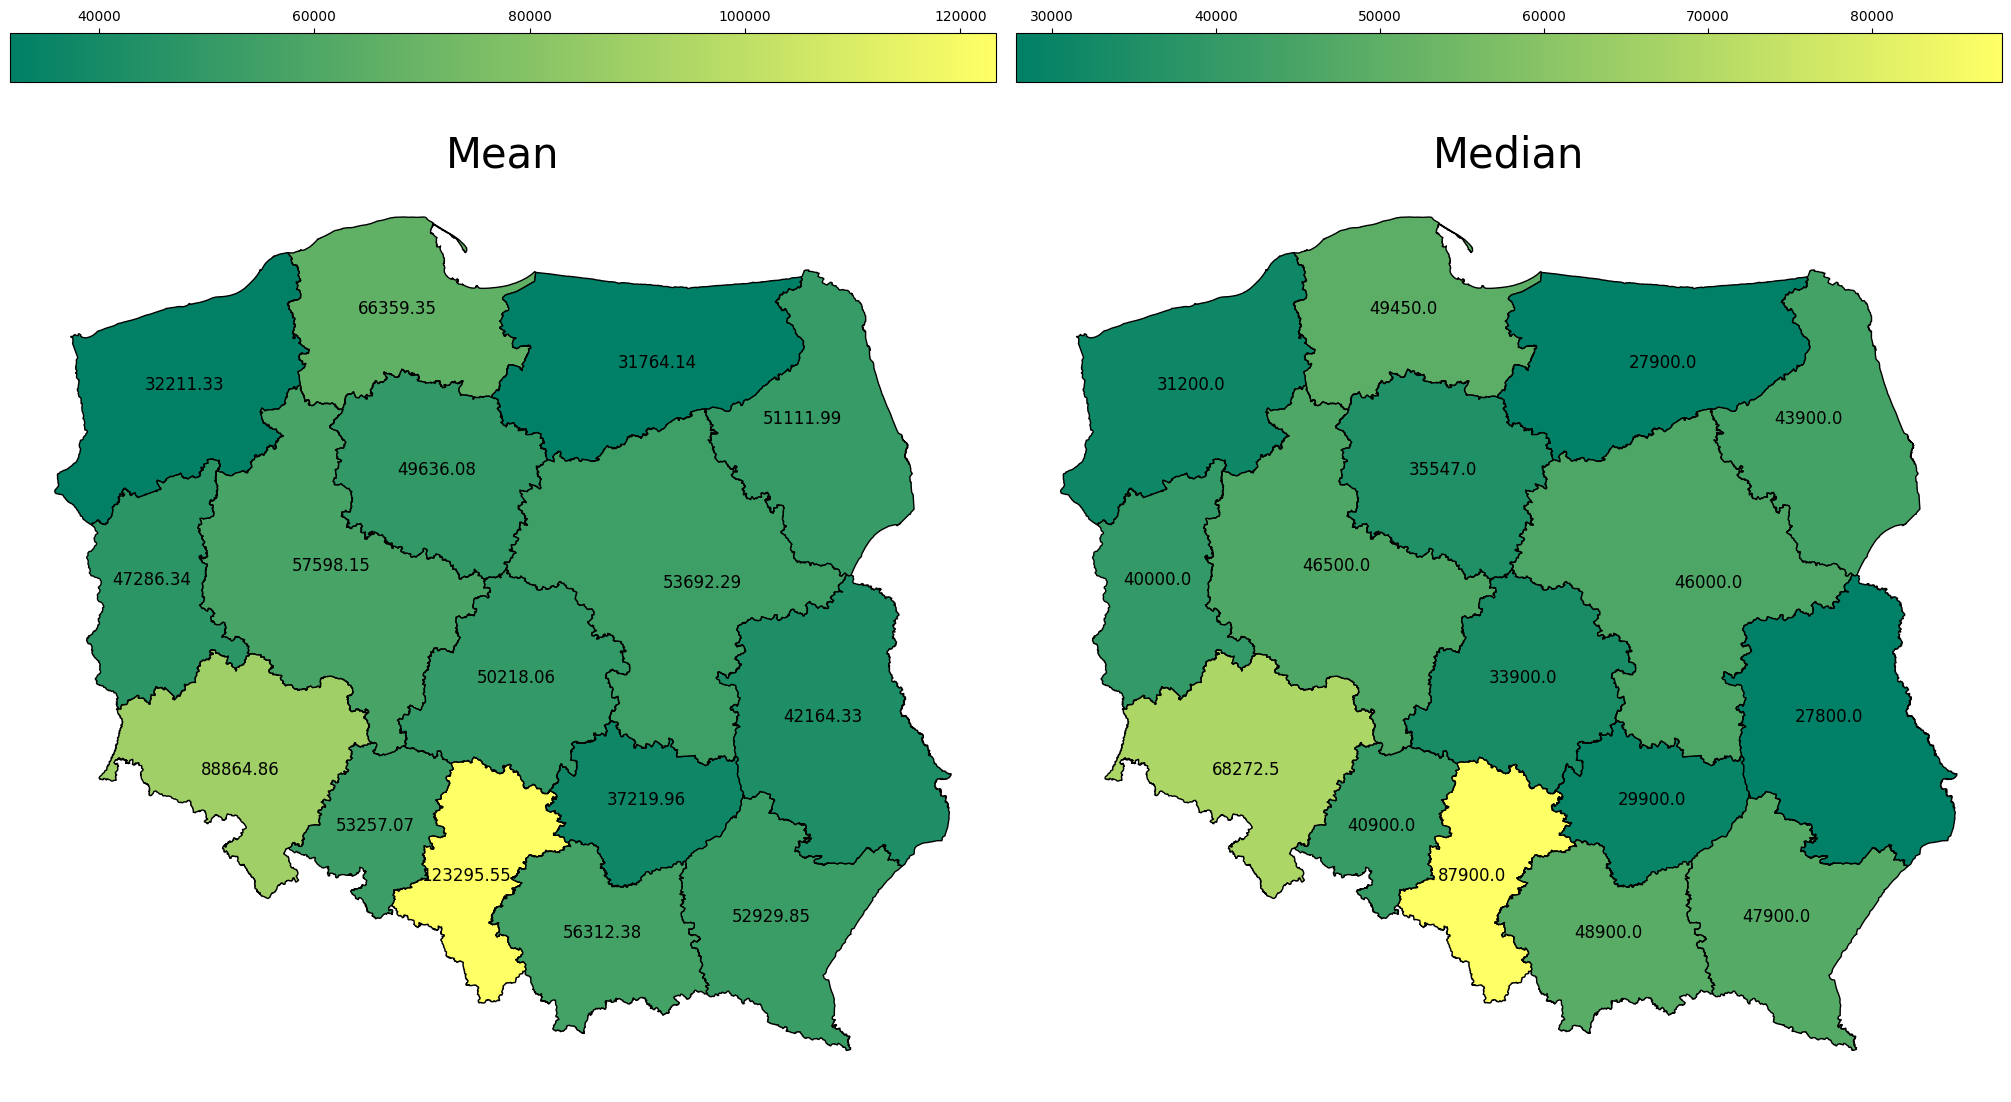

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,12),constrained_layout=True)
#Creating a colormap with colorbar for median map
vmin_median = mapa_woj['median'].min()
vmax_median = mapa_woj['median'].max()
mappable_median = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin_median, vmax=vmax_median),cmap='summer')
color_median = [mappable_median.to_rgba(item) for item in mapa_woj['median']]
fig.colorbar(mappable_median,ax=ax2,location='top')

#Creating a colormap with colorbar for mean map
vmin_mean = mapa_woj['mean'].min()
vmax_mean = mapa_woj['mean'].max()
mappable_mean = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin_mean, vmax=vmax_mean),cmap='summer')
color_mean = [mappable_mean.to_rgba(item) for item in mapa_woj['mean']]
fig.colorbar(mappable_mean,ax=ax1,location='top')


# Mean map
mapa_woj.plot(ax=ax1, color=color_mean, edgecolor='black')
ax1.axis('off')
for idx, row in mapa_woj.iterrows():
    ax1.annotate(text=row['mean'], xy=row['coords'], 
                 horizontalalignment='center', color='black', fontsize=12
    )
ax1.set_title('Mean', fontsize=30)

# Median map
mapa_woj.plot(ax=ax2, color=color_median, edgecolor='black')
ax2.axis('off')
for idx, row in mapa_woj.iterrows():
    ax2.annotate(
        text=row['median'], xy=row['coords'], 
        horizontalalignment='center', color='black', fontsize=12
    )
ax2.set_title('Median', fontsize=30)
plt.show()    

Most popular brand in voivodeship

In [53]:
top = {}
for voivo in df['wojewodztwo'].unique():
    top[voivo] = {'top': df[df['wojewodztwo']==f'{voivo}']['marka'].value_counts(ascending=False).index[0]}
top = pd.DataFrame(top).T

In [54]:
mapa_woj= mapa_woj.join(top, on=mapa_woj.woj)


In [55]:
brands = dict(zip(mapa_woj['top'].unique(),range(len(mapa_woj['top'].unique()))))
mapa_woj['top_int'] = mapa_woj['top'].apply(lambda x: brands[x])

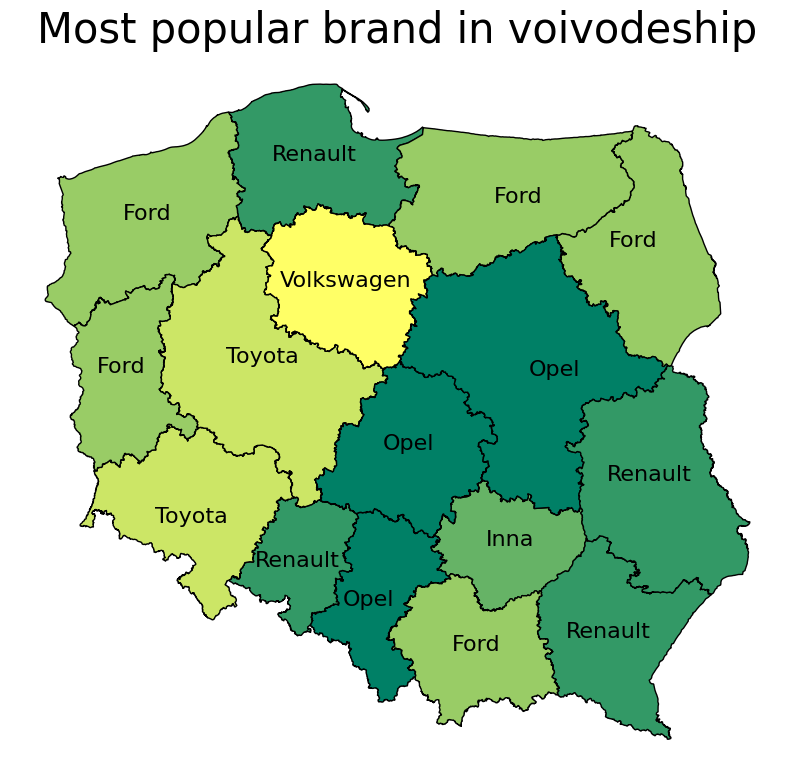

In [56]:
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Most popular brand in voivodeship',
          fontsize=30
         )
# Coloring a map.
vmin = mapa_woj['top_int'].min()
vmax = mapa_woj['top_int'].max()
mappable = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='summer')
color = [mappable.to_rgba(item) for item in mapa_woj['top_int']]

mapa_woj.plot(ax=ax, color=color, edgecolor='black')
ax.axis('off')
for idx, row in mapa_woj.iterrows():
    plt.annotate(
        text=row['top'], 
        xy=row['coords'], 
        horizontalalignment='center', 
        color='black',
        fontsize=16
    )

Most popular fuel type

In [57]:
fuel_type = {}
for voivo in df['wojewodztwo'].unique():
    fuel_type[voivo] = {'fuel_type': df[df['wojewodztwo']==f'{voivo}']['rodzaj_paliwa'].value_counts(ascending=False).index[0]}
fuel_type = pd.DataFrame(fuel_type).T

In [58]:
mapa_woj= mapa_woj.join(fuel_type, on=mapa_woj.woj)



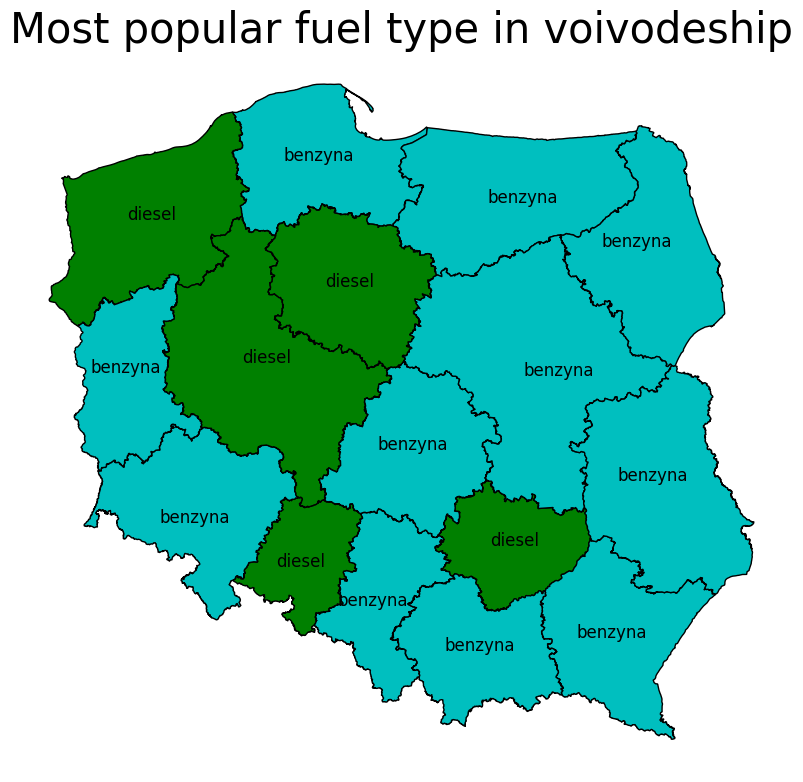

In [59]:
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Most popular fuel type in voivodeship', 
          fontsize=30
         )
color = ['c' if item=='benzyna' else 'g' for item in mapa_woj['fuel_type']]
mapa_woj.plot(ax=ax, color=color, edgecolor='black')
ax.axis('off')
for idx, row in mapa_woj.iterrows():
    plt.annotate(
        text=row['fuel_type'], 
        xy=row['coords'], 
        horizontalalignment='center', 
        color='black',
        fontsize=12
    )

Quantity of advertises in each voivodeship

In [60]:
num_of_ads = {}
for voivo in df['wojewodztwo'].unique():
    num_of_ads[voivo] = {'num_of_ads': df[df['wojewodztwo']==f'{voivo}'].shape[0]}
num_of_ads = pd.DataFrame(num_of_ads).T

In [61]:
mapa_woj= mapa_woj.join(num_of_ads, on=mapa_woj.woj)

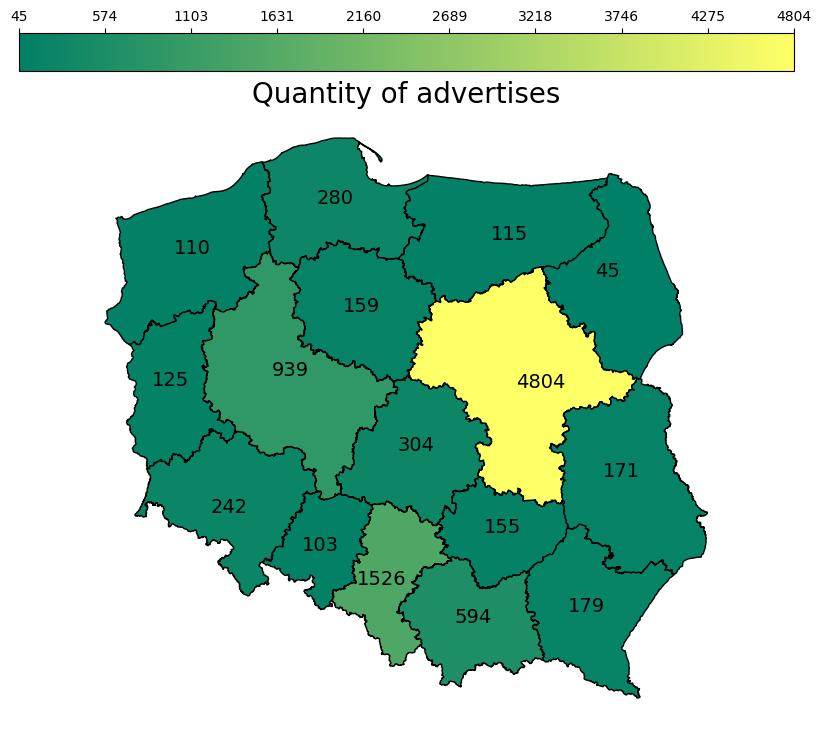

In [62]:
import numpy
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Quantity of advertises', fontsize=20)


#Creating a colormap with colorbar
vmin = mapa_woj['num_of_ads'].min()
vmax = mapa_woj['num_of_ads'].max()
mappable = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='summer')
color = [mappable.to_rgba(item) for item in mapa_woj['num_of_ads']]
fig.colorbar(mappable,ax=ax,location='top',ticks=np.linspace(start=vmin, stop=vmax, num=10))

mapa_woj.plot(ax=ax,color=color, edgecolor='black')
ax.axis('off')
for idx, row in mapa_woj.iterrows():
    plt.annotate(
        text=row['num_of_ads'], 
        xy=row['coords'], 
        horizontalalignment='center', 
        color='black',
        fontsize=14
    )

Generating subplots with top 5 brand in each voivodeship

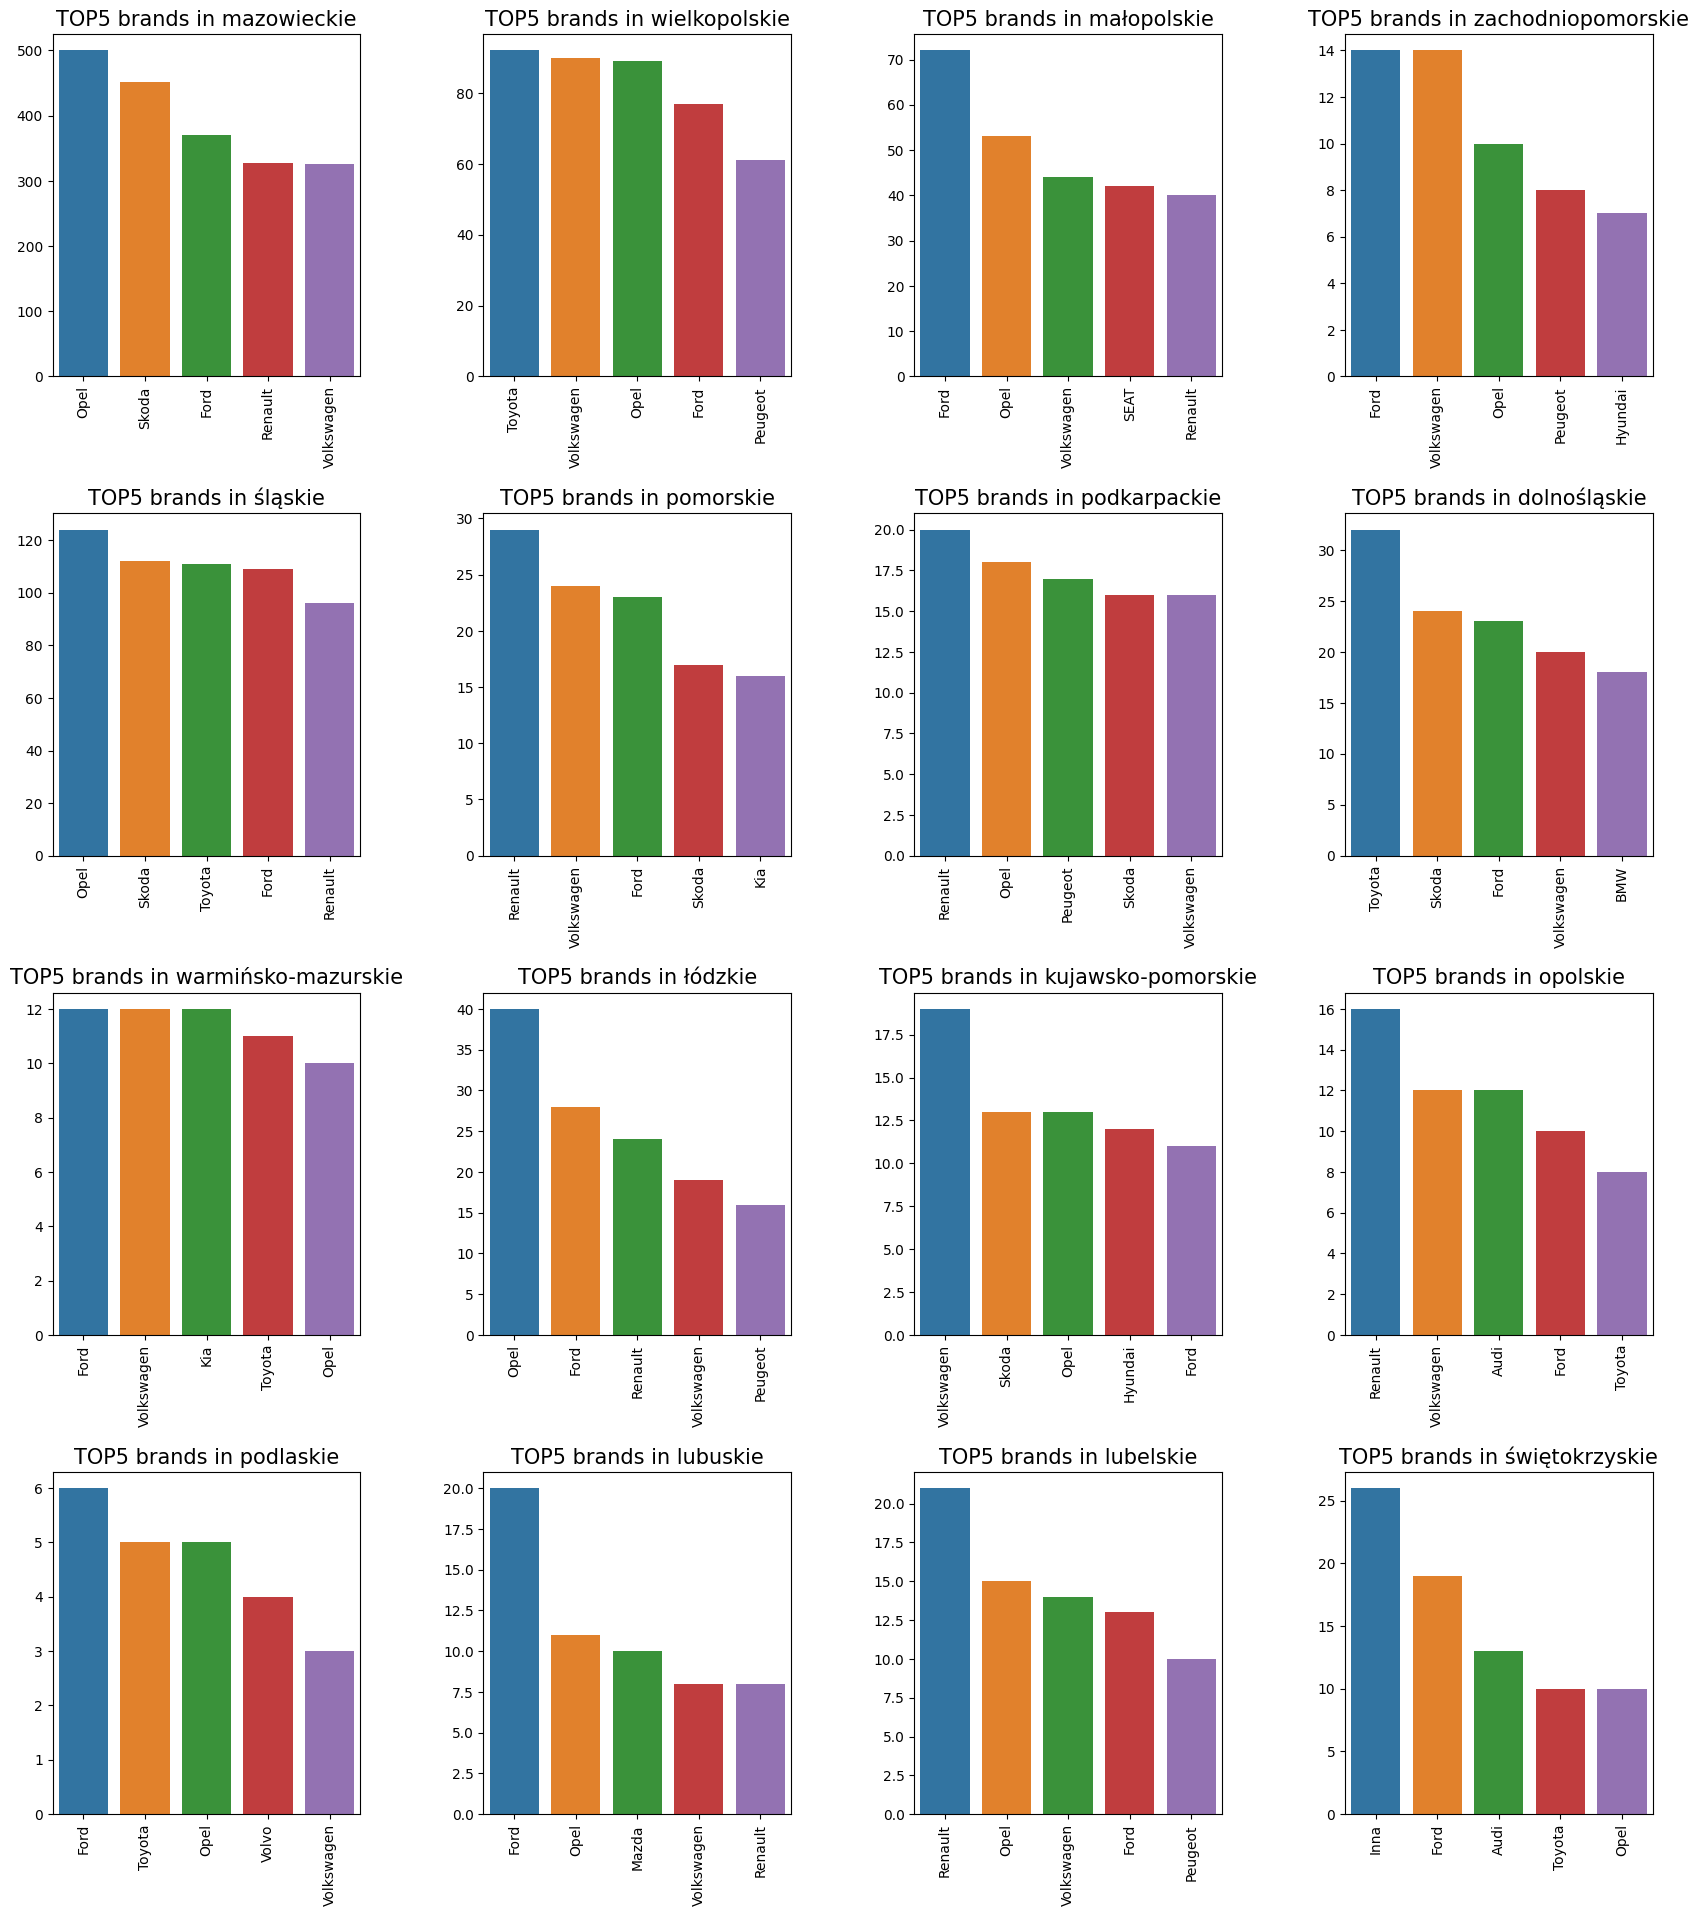

In [63]:
top = {}
for voivo in df['wojewodztwo'].unique():
    top[voivo] = {'top': df[df['wojewodztwo']==f'{voivo}']['marka'].value_counts(ascending=False)[:5]}
voivodeship_iterator = iter(list(df.wojewodztwo.unique()[:-1]))
voivodeship_name = iter(list(top.keys()))


plt.figure(figsize=(20, 20))
for x in range(4):
    for y in range(4):
        ax = plt.subplot2grid((4,4), (x,y))
        voivodeship = top[next(voivodeship_iterator)]['top']
        plt.title(f'TOP5 brands in {next(voivodeship_name)}', fontsize=15)
        voivodeship=pd.DataFrame({'count':voivodeship.values},index=voivodeship.index)
        sns.barplot(x=voivodeship.index,y=list(voivodeship['count'].values))
        plt.xticks(rotation=90)
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

Top model in every brand

In [64]:
brands = df.marka.unique()
top_models = {}
for brand in brands:
    top_models[brand] = df[df['marka'] == brand]['model'].value_counts().index[0]
pd.DataFrame({'marka': top_models.keys(), 'model': top_models.values()}).drop(labels=[0,20,29,36,48],axis=0) 
#dropped values where model type was 'other'

,marka,model
1,BMW,SERIA 3 F30/F31/F34
2,Peugeot,308 II
3,SEAT,Leon III
4,Suzuki,Vitara II
5,Toyota,Yaris III
6,Volkswagen,Passat B8
7,Opel,Astra J
8,Kia,Sportage III
9,Skoda,Octavia III
10,Ford,Focus III
